### Importing libraries

In [40]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy.stats import norm, skew, kurtosis 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import catboost as cb
from catboost import Pool, CatBoostRegressor
from xgboost import XGBRegressor, plot_importance, cv
import xgboost as xgb
from fuzzywuzzy import fuzz,process

# CatBoostRegressor
from tabnanny import verbose

#pip install pytorch-tabnet
#from pytorch_tabnet.tab_model import TabNetRegressor

### Data wrangling

#### Daily tracking data

For a specific data, this game, had that position on that operator

In [4]:
daily_tracking = 'data/iGamingtracker/igamingtracker_DailyTracking.csv'

In [5]:
tracking_df = pd.read_csv(daily_tracking,dtype={'DatePageLink': 'Int64'})
tracking_df.head()

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID,locationID,Location,column,Row,Active,PageID,Weighting_Tile
0,2107021551,1731701560,2021-07-02,3260882,396377,0.0054,3.9664,1,30,29673,3260882,30,2,6,1,1551,1
1,2107021551,1731700815,2021-07-02,3260862,396294,0.0203,14.9128,1,10,29618,3260862,10,4,2,1,1551,1
2,2107026521,1731149288,2021-07-02,2141971,3950,0.0029,0.2108,6,208,2269,2141971,208,17,8,0,6521,2
3,2107028554,1731147522,2021-07-02,3182900,3816,0.0025,0.1807,13,75,7030,3182900,75,3,19,0,8554,1
4,2107028554,1731146977,2021-07-02,3183227,3802,0.0010,0.0716,13,402,3948,3183227,402,2,101,0,8554,1


In [927]:
tracking_df.shape

(422928, 17)

In [928]:
tracking_df.columns

Index(['DatePageLink', 'ID', 'Date', 'LocationID', 'SearchStringID',
       'LocationWeighting', 'WeightedDays', 'PageTypeID', 'Name', 'GameID',
       'locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile'],
      dtype='object')

In [929]:
tracking_df['PageID'].value_counts()

2125    100260
117      86788
6521     80029
8554     74089
1551     53402
9883     28360
Name: PageID, dtype: int64

In [930]:
tracking_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DatePageLink,422436.0,1.772671e+09,7.912713e+08,2.107021e+08,2.107249e+09,2.201192e+09,2.205112e+09,2.208310e+09
ID,422928.0,1.903829e+09,9.007691e+07,1.731140e+09,1.836848e+09,1.910678e+09,1.978174e+09,2.049933e+09
LocationID,422928.0,3.163918e+06,8.290764e+05,4.238510e+05,3.182832e+06,3.438269e+06,3.844978e+06,4.676132e+06
SearchStringID,422928.0,3.227216e+05,1.533083e+05,7.000000e+00,2.561570e+05,3.794380e+05,4.344500e+05,5.448060e+05
LocationWeighting,422584.0,5.464431e-03,8.079053e-03,7.000000e-04,1.700000e-03,2.800000e-03,4.800000e-03,1.018000e-01
WeightedDays,421021.0,2.199213e+00,4.379860e+00,9.100000e-03,2.468000e-01,8.989000e-01,2.031800e+00,7.251540e+01
PageTypeID,422928.0,1.073890e+01,9.072148e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.300000e+01,2.300000e+01
Name,422928.0,1.126120e+02,8.099906e+01,1.000000e+00,4.900000e+01,1.000000e+02,1.610000e+02,4.200000e+02
GameID,422928.0,2.487096e+04,8.045862e+03,5.400000e+01,2.186400e+04,2.753700e+04,3.081200e+04,3.377700e+04
locationID,422928.0,3.163918e+06,8.290764e+05,4.238510e+05,3.182832e+06,3.438269e+06,3.844978e+06,4.676132e+06


In [931]:
tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422928 entries, 0 to 422927
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DatePageLink       422436 non-null  Int64  
 1   ID                 422928 non-null  int64  
 2   Date               422928 non-null  object 
 3   LocationID         422928 non-null  int64  
 4   SearchStringID     422928 non-null  int64  
 5   LocationWeighting  422584 non-null  float64
 6   WeightedDays       421021 non-null  float64
 7   PageTypeID         422928 non-null  int64  
 8   Name               422928 non-null  int64  
 9   GameID             422928 non-null  int64  
 10  locationID         422928 non-null  int64  
 11  Location           422928 non-null  int64  
 12  column             422928 non-null  int64  
 13  Row                422928 non-null  int64  
 14  Active             422928 non-null  int64  
 15  PageID             422928 non-null  int64  
 16  We

In [932]:
tracking_df['WeightedDays'].value_counts()

0.1090     108
0.1101     105
0.1083     102
0.1114     101
0.1095     100
          ... 
18.4128      1
21.4315      1
6.8262       1
26.6956      1
4.7417       1
Name: WeightedDays, Length: 77531, dtype: int64

#### Games

In [4]:
games_df = pd.read_csv('data/iGamingtracker/igamingtracker_Games.csv')
games_df.head()

,SearchNameID,GameID,Game,SearchName,BrandID,Brand,Supplier ID,Supplier,Gametype,SearchstringID,...,Reels,FreeGame,Achievements,MinBet,MaxBet,HitRate,Volatility,MaxExposure,BVGameName,gametypeid
0,498964,16657,Apollo God of the Sun (Leander),apollogodotsun10wwde,186,Green Tube,25,Novomatic,Progressive Jackpots,498964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apollo - God of the Sun,4
1,498965,33200,Master Of Eclipse,masterofeclipse,352,Synot,299,Synot,Slots,498965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,499081,33213,Ways Of The Gaul,waysofgauls,361,Platipus,308,Platipus,Slots,499081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,499082,33578,Roulette Palm Beach - Authentic Gaming,roulettepalmbeach,278,Authentic Gaming,188,Authentic Gaming,Live Games,499082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,499083,33196,Da Vinci Gems,davincigemsrackingupriches,84,High5Games,66,High5Games,Slots,499083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
games_df.columns

Index(['SearchNameID', 'GameID', 'Game', 'SearchName', 'BrandID', 'Brand',
       'Supplier ID', 'Supplier', 'Gametype', 'SearchstringID', 'BrandedGame',
       'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame', 'Achievements',
       'MinBet', 'MaxBet', 'HitRate', 'Volatility', 'MaxExposure',
       'BVGameName', 'gametypeid'],
      dtype='object')

In [934]:
games_df.shape

(301445, 24)

In [935]:
games_df.columns

Index(['SearchNameID', 'GameID', 'Game', 'SearchName', 'BrandID', 'Brand',
       'Supplier ID', 'Supplier', 'Gametype', 'SearchstringID', 'BrandedGame',
       'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame', 'Achievements',
       'MinBet', 'MaxBet', 'HitRate', 'Volatility', 'MaxExposure',
       'BVGameName', 'gametypeid'],
      dtype='object')

In [936]:
games_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SearchNameID,301445.0,270313.795316,1.438193e+05,1.00000,152404.0000,278254.0000,384287.0000,548125.0
GameID,301445.0,19932.486284,7.773559e+03,11.00000,17024.0000,21868.0000,23631.0000,33866.0
BrandID,301445.0,254.610838,1.868047e+02,3.00000,75.0000,199.0000,450.0000,761.0
Supplier ID,301445.0,102.701179,1.235835e+02,1.00000,17.0000,57.0000,116.0000,676.0
SearchstringID,301445.0,270313.795316,1.438193e+05,1.00000,152404.0000,278254.0000,384287.0000,548125.0
BrandedGame,69695.0,0.081024,2.728746e-01,0.00000,0.0000,0.0000,0.0000,1.0
RTPHigh,168856.0,0.980462,1.124645e+00,0.00000,0.9600,0.9643,0.9709,96.0
RTPLow,27720.0,0.285626,4.278841e-01,0.00000,0.0000,0.0000,0.8950,1.0
Lines,94426.0,83341.909929,3.139171e+06,0.00000,10.0000,20.0000,50.0000,191102976.0
Reels,100535.0,93.251584,4.029779e+03,0.00000,5.0000,5.0000,5.0000,200704.0


In [937]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301445 entries, 0 to 301444
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SearchNameID    301445 non-null  int64  
 1   GameID          301445 non-null  int64  
 2   Game            301445 non-null  object 
 3   SearchName      301439 non-null  object 
 4   BrandID         301445 non-null  int64  
 5   Brand           301445 non-null  object 
 6   Supplier ID     301445 non-null  int64  
 7   Supplier        301445 non-null  object 
 8   Gametype        301445 non-null  object 
 9   SearchstringID  301445 non-null  int64  
 10  BrandedGame     69695 non-null   float64
 11  RTPHigh         168856 non-null  float64
 12  RTPLow          27720 non-null   float64
 13  Lines           94426 non-null   float64
 14  Reels           100535 non-null  float64
 15  FreeGame        84332 non-null   float64
 16  Achievements    71456 non-null   float64
 17  MinBet    

In [938]:
games_df['GameID'].nunique()

21480

In [939]:
games_df.nunique()

SearchNameID      301445
GameID             21480
Game               21471
SearchName        295461
BrandID              592
Brand                592
Supplier ID          511
Supplier             511
Gametype              23
SearchstringID    301445
BrandedGame            2
RTPHigh              640
RTPLow               214
Lines                179
Reels                 23
FreeGame               2
Achievements           2
MinBet                64
MaxBet               161
HitRate              640
Volatility            22
MaxExposure         1137
BVGameName         16562
gametypeid            23
dtype: int64

In [940]:
games_df['Gametype'].value_counts()

Slots                   147410
Table Games              70950
Live Games               44665
Progressive Jackpots     17819
Megaways                  6763
Game Shows                4075
Jackpot                   2543
Instant Win               1822
First Person              1293
Hold and Win              1276
Bingo                      823
Slingo                     556
Dice                       514
Cluster Pays               439
Video Bingo                209
MegaClusters               113
Casual Games                59
Keno                        50
Virtual Sports              29
Multiplayer                 24
Lottery Games                7
Mine Games                   4
Traditional Slots            2
Name: Gametype, dtype: int64

#### Game Themes

In [941]:
themes_df = pd.read_csv('data/iGamingtracker/igamingtracker_GameThemes.csv')
themes_df.head()

,ID,Theme,GameID
0,3,Roulette,9455
1,3,Roulette,20998
2,3,Roulette,21005
3,3,Roulette,21008
4,3,Roulette,21009


In [942]:
themes_df.shape

(44187, 3)

In [943]:
themes_df['Theme'].value_counts()

Animals                   1329
Classic Fruits            1018
Chinese                    814
Money/Treasure/Jewelry     737
Egypt                      686
                          ... 
Price                        1
Puppies                      1
Kitten                       1
Elevation                    1
Gonzo                        1
Name: Theme, Length: 1559, dtype: int64

In [944]:
themes_df['GameID'].nunique()

20642

#### Location Grid

In [945]:
# (games_df has the locationID to tie them together)

locationgrid_df = pd.read_csv('data/iGamingtracker/igamingtracker_LocationGrid.csv')
locationgrid_df.head()

,locationID,Location,column,Row,Active,PageID,Weighting_Tile
0,8366,1,1,1,0,117,1
1,8367,2,2,1,0,117,1
2,8368,3,3,1,0,117,1
3,8369,4,1,2,0,117,1
4,8370,5,2,2,0,117,1


In [946]:
locationgrid_df.shape

(3225, 7)

In [947]:
locationgrid_df.columns

Index(['locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile'],
      dtype='object')

In [948]:
locationgrid_df['Weighting_Tile'].value_counts()

1    2668
2     491
4      66
Name: Weighting_Tile, dtype: int64

In [949]:
locationgrid_df['PageID'].value_counts()

117     992
8554    635
2125    595
6521    459
1551    346
9883    198
Name: PageID, dtype: int64

In [950]:
locationgrid_df['Active'].value_counts()

0    1987
1    1238
Name: Active, dtype: int64

#### Pages

In [951]:
pages_df = pd.read_csv('data/iGamingtracker/igamingtracker_Pages.csv')
pages_df.head()

,Page,Site,Country,Country (States Combined),Continent,Site Group,Page Type,Page ID,SiteID,URL,...,Site Type,SiteCountryTier,Weighting_Page,SiteTierID,Weighting_Site,Weighting_Country,Active,Regulated,ProxyID,Proxy
0,32Red Games Home UK,32red,United Kingdom,United Kingdom,Europe,Kindred plc,Main Page,117,22,https://www.32red.com/,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
1,32red Home Mobile UK,32red,United Kingdom,United Kingdom,Europe,Kindred plc,Main Page,1551,22,https://www.32red.com/,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
2,32Red Games - Logged In UK,32red,United Kingdom,United Kingdom,Europe,Kindred plc,Logged In Main Page,2125,22,https://www.32red.com/,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
3,32Red Casino Slots UK,32red,United Kingdom,United Kingdom,Europe,Kindred plc,Slots,6521,22,https://www.32red.com/casino/slots,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
4,32Red Casino All Games UK - Logged In,32red,United Kingdom,United Kingdom,Europe,Kindred plc,All Games,8554,22,https://www.32red.com/casino/slots,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom


In [952]:
pages_df.shape

(6, 31)

In [953]:
pages_df.columns

Index(['Page', 'Site', 'Country', 'Country (States Combined)', 'Continent',
       'Site Group', 'Page Type', 'Page ID', 'SiteID', 'URL', 'LoadType',
       'Mobile/Desktop', 'CountryID', 'PagetypeID', 'ManufacturerID',
       'ScreenshotURL', 'Exclusive Page Manufacturer ID', 'Page First Tracked',
       'Page Last Tracked', 'SiteGroupID', 'SiteTypeID', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'SiteTierID', 'Weighting_Site',
       'Weighting_Country', 'Active', 'Regulated', 'ProxyID', 'Proxy'],
      dtype='object')

In [954]:
pages_df['Site Group']

0    Kindred plc
1    Kindred plc
2    Kindred plc
3    Kindred plc
4    Kindred plc
5    Kindred plc
Name: Site Group, dtype: object

In [955]:
pages_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Page ID,6.0,4791.833333,4.062831e+03,117.000,1694.500,4323.000,8045.750,9883.000
SiteID,6.0,22.000000,0.000000e+00,22.000,22.000,22.000,22.000,22.000
LoadType,6.0,1.333333,5.163978e-01,1.000,1.000,1.000,1.750,2.000
CountryID,6.0,1.000000,0.000000e+00,1.000,1.000,1.000,1.000,1.000
PagetypeID,6.0,11.166667,1.016694e+01,1.000,2.250,9.500,20.500,23.000
ManufacturerID,6.0,10.500000,1.040673e+01,1.000,1.000,10.500,20.000,20.000
Exclusive Page Manufacturer ID,6.0,10.500000,1.040673e+01,1.000,1.000,10.500,20.000,20.000
SiteGroupID,6.0,28.000000,0.000000e+00,28.000,28.000,28.000,28.000,28.000
SiteTypeID,6.0,2.000000,0.000000e+00,2.000,2.000,2.000,2.000,2.000
SiteCountryTier,6.0,3.000000,0.000000e+00,3.000,3.000,3.000,3.000,3.000


In [956]:
pages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Page                            6 non-null      object 
 1   Site                            6 non-null      object 
 2   Country                         6 non-null      object 
 3   Country (States Combined)       6 non-null      object 
 4   Continent                       6 non-null      object 
 5   Site Group                      6 non-null      object 
 6   Page Type                       6 non-null      object 
 7   Page ID                         6 non-null      int64  
 8   SiteID                          6 non-null      int64  
 9   URL                             6 non-null      object 
 10  LoadType                        6 non-null      int64  
 11  Mobile/Desktop                  6 non-null      object 
 12  CountryID                       6 non-nu

In [957]:
pages_df['Page'].nunique()

6

#### Performance data

* GAME_GROUP_ID - Unique identifier for each game 
* Numbets - Numbers of bets on a given day
* Turnover - Amount wagered on that game on a given day
* GGR - Gross gaming revenue on a given day 
* Count - How many unique players wagered on that game on a given day


In [958]:
performance_df = pd.read_csv('data/performance/performance_daily.csv')
performance_df.head()

,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID)
0,2022-08-31 00:00:00.000,248,118,105.33393,15.42790,5
1,2022-08-31 00:00:00.000,249,2170,2596.69160,372.52896,5
2,2022-08-31 00:00:00.000,290,3048,3295.06510,-425.66789,12
3,2022-08-31 00:00:00.000,295,3866,2851.06594,14.22690,22
4,2022-08-31 00:00:00.000,298,46004,69230.14624,-6683.75993,354


In [959]:
performance_df[performance_df['GAME_GROUP_ID']==248]

,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID)
0,2022-08-31 00:00:00.000,248,118,105.33393,15.42790,5
412,2022-08-30 00:00:00.000,248,137,273.35526,21.65773,5
832,2022-08-29 00:00:00.000,248,35,30.14543,22.75685,3
1258,2022-08-28 00:00:00.000,248,72,53.78900,-3.25084,3
1664,2022-08-27 00:00:00.000,248,59,34.87431,9.75313,2
...,...,...,...,...,...,...
67314,2022-03-01 00:00:00.000,248,17324,29195.39162,3485.46680,306
67649,2022-02-28 00:00:00.000,248,19284,20674.75803,2772.74160,341
67982,2022-02-27 00:00:00.000,248,12891,18320.13692,2408.49864,267
68311,2022-02-26 00:00:00.000,248,19444,21126.41248,3018.60204,412


In [960]:
# Unique values in each column of performance dataframe 

performance_df.nunique()

BEGINTIME                       427
GAME_GROUP_ID                   541
NUMBETS                       20821
TURNOVER                     133987
GGR                          134805
COUNT(DISTINCTACCOUNT_ID)       603
dtype: int64

In [961]:
performance_df.shape

(135133, 6)

In [962]:
performance_df.columns

Index(['BEGINTIME', 'GAME_GROUP_ID', 'NUMBETS', 'TURNOVER', 'GGR',
       'COUNT(DISTINCTACCOUNT_ID)'],
      dtype='object')

#### Performance metadata

In [963]:
perf_meta_df = pd.read_csv('data/performance/performance_metadata.csv')
perf_meta_df.head()

,GAME_GROUP_ID,GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,671,Chilli Gold 2,2nd Party,Lightning Box (GDM)
1,685,Dragon Palace,2nd Party,Lightning Box (GDM)
2,518,Mad Mad Monkey,1st Party,NextGen Standard (GDM)
3,535,Medusa,1st Party,NextGen Standard (GDM)
4,545,Merlin's Millions Superbet,1st Party,NextGen Standard (GDM)


In [964]:
perf_meta_df['GAME_GROUP_ID'].value_counts()

1875    3
3742    2
4110    2
298     2
671     1
       ..
1181    1
4515    1
3751    1
1172    1
2520    1
Name: GAME_GROUP_ID, Length: 469, dtype: int64

In [965]:
perf_meta_df.nunique()

GAME_GROUP_ID         469
GAME_GROUP_NAME       469
PROVIDER_PARTY          3
GAME_PROVIDER_NAME     21
dtype: int64

In [966]:
perf_meta_df.shape

(474, 4)

#### Performance joined

We have to make sure that we don't have any duplicates on performance data.

In [967]:
new_performance_df = performance_df.drop_duplicates(
  subset = ['BEGINTIME', 'GAME_GROUP_ID'],
  keep = 'first').reset_index(drop = True)

In [968]:
new_performance_df.shape

(135133, 6)

In [969]:
perf_meta_df.shape

(474, 4)

In [970]:
perf_meta_df.nunique()


GAME_GROUP_ID         469
GAME_GROUP_NAME       469
PROVIDER_PARTY          3
GAME_PROVIDER_NAME     21
dtype: int64

In [971]:
new_perf_meta_df = perf_meta_df.drop_duplicates(
    subset = ['GAME_GROUP_ID', 'GAME_GROUP_NAME','GAME_PROVIDER_NAME','PROVIDER_PARTY'],
    keep = 'first').reset_index(drop = True)

In [972]:
new_perf_meta_df.shape

(469, 4)

In [973]:
new_perf_meta_df.nunique()


GAME_GROUP_ID         469
GAME_GROUP_NAME       469
PROVIDER_PARTY          3
GAME_PROVIDER_NAME     21
dtype: int64

Indeed performance data had 5 true duplicates that did cause trouble when joining with the performance data so we got rid of those.

Joining those two dataframes on GAME_GROUP_ID to get the name of the game 

In [974]:
perf_df = pd.merge(new_performance_df, new_perf_meta_df, on='GAME_GROUP_ID', how='left')

In [975]:
perf_df.shape

(135133, 9)

And after joining, we end up with exactly the same records, hence the join was succesful

In [976]:
perf_df.head()

,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,2022-08-31 00:00:00.000,248,118,105.33393,15.42790,5,NaN,NaN,NaN
1,2022-08-31 00:00:00.000,249,2170,2596.69160,372.52896,5,Bruce Lee,1st Party,Scientific Games
2,2022-08-31 00:00:00.000,290,3048,3295.06510,-425.66789,12,Raging Rhino,1st Party,Scientific Games
3,2022-08-31 00:00:00.000,295,3866,2851.06594,14.22690,22,Spartacus,1st Party,Scientific Games
4,2022-08-31 00:00:00.000,298,46004,69230.14624,-6683.75993,354,Rainbow Riches,1st Party,Scientific Games


Dropping NAs - aka games that did not have any names, after all we won't be able to match those with the other data

In [977]:
perf_df.dropna(subset=['GAME_GROUP_NAME'], inplace=True)
perf_df.shape

(119567, 9)

Saving this new dataframe as perf_full_df for later use

In [978]:
perf_df.to_csv('data/performance/full_perf.csv',index=False)

Sanity check loading data

In [979]:
df = pd.read_csv('data/performance/full_perf.csv')
df.shape

(119567, 9)

In [980]:
df.head()

,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,2022-08-31 00:00:00.000,249,2170,2596.69160,372.52896,5,Bruce Lee,1st Party,Scientific Games
1,2022-08-31 00:00:00.000,290,3048,3295.06510,-425.66789,12,Raging Rhino,1st Party,Scientific Games
2,2022-08-31 00:00:00.000,295,3866,2851.06594,14.22690,22,Spartacus,1st Party,Scientific Games
3,2022-08-31 00:00:00.000,298,46004,69230.14624,-6683.75993,354,Rainbow Riches,1st Party,Scientific Games
4,2022-08-31 00:00:00.000,299,1674,5716.76993,264.28930,15,Montezuma,1st Party,Scientific Games


#### Combining iGamingTracker data

##### First, let's combine games with their themes

In [981]:
games_df.shape

(301445, 24)

In [982]:
games_df.nunique()[:2]

SearchNameID    301445
GameID           21480
dtype: int64

As we can see, we have 301k of games records with only 21.480 unique games. I am guessing we have the same games, but from different suppliers. 

In [983]:
themes_df.shape

(44187, 3)

In [984]:
themes_df.nunique()

ID         1560
Theme      1559
GameID    20642
dtype: int64

We have 20642 unique games with themes.

In [985]:
duplicateRows = themes_df[themes_df.duplicated(['GameID'])]

In [986]:
duplicateRows

,ID,Theme,GameID
488,4,Blackjack,21021
761,4,Blackjack,29924
958,6,Baccarat,32619
1160,8,Poker,33497
1161,8,Poker,33498
...,...,...,...
44180,1582,Zoo,19100
44181,1582,Zoo,24491
44182,1582,Zoo,29208
44185,1583,Zuma,31465


In [987]:
themes_df[themes_df['GameID']==29924]

,ID,Theme,GameID
332,3,Roulette,29924
761,4,Blackjack,29924
31275,839,Instant,29924
36153,1131,Plus,29924
36648,1164,Quantum,29924


Looks like we don't have true duplicates here, it's just weird data entry. I am guessing that game with ID 29924, is a game representing lot of themes. So it's roulette, blackhack, instant, plus and quantum.

I believe a better representation of that df would consist of a unique GameID and a column called themes, with all available themes.

In [988]:
new_themes = themes_df.groupby(['GameID'])['Theme'].apply(','.join).reset_index()

In [989]:
new_themes

,GameID,Theme
0,11,"Chinese,Hidden,Temple"
1,12,Wild West
2,16,"Egypt,Treasure"
3,17,"Animals,Rush"
4,20,"Egypt,Ramses"
...,...,...
20637,33870,Piggy
20638,33871,"Aztec,Fire"
20639,33872,Dracula
20640,33873,Egypt


In [990]:
new_themes.nunique()

GameID    20642
Theme     11796
dtype: int64

For now, let's just combine games and themes together

In [991]:
games_w_themes_df = pd.merge(games_df, new_themes, on='GameID', how='left')

Sanity check for the new dataframe's dimensions

In [992]:
games_df.shape

(301445, 24)

In [993]:
games_w_themes_df.shape

(301445, 25)

In [994]:
games_w_themes_df.head()

,SearchNameID,GameID,Game,SearchName,BrandID,Brand,Supplier ID,Supplier,Gametype,SearchstringID,...,FreeGame,Achievements,MinBet,MaxBet,HitRate,Volatility,MaxExposure,BVGameName,gametypeid,Theme
0,498964,16657,Apollo God of the Sun (Leander),apollogodotsun10wwde,186,Green Tube,25,Novomatic,Progressive Jackpots,498964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apollo - God of the Sun,4,"Gods,Sun,Apollo,God"
1,498965,33200,Master Of Eclipse,masterofeclipse,352,Synot,299,Synot,Slots,498965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Stars,Eclipse,Master"
2,499081,33213,Ways Of The Gaul,waysofgauls,361,Platipus,308,Platipus,Slots,499081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"French,Ways"
3,499082,33578,Roulette Palm Beach - Authentic Gaming,roulettepalmbeach,278,Authentic Gaming,188,Authentic Gaming,Live Games,499082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"Roulette,Beach,Gaming"
4,499083,33196,Da Vinci Gems,davincigemsrackingupriches,84,High5Games,66,High5Games,Slots,499083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Adventure,Gems,Vinci"


Wider representation for themes by getting dummies just to exist here for now.

In [995]:
themes_dummies = games_w_themes_df['Theme'].str.get_dummies(sep=",")

In [996]:
themes_dummies.head()

,Native American,3 Card Brag,Absolute,Academy,Ace,Action,Admiral,Adventure,Africa,Age,...,Zombie,Zone,Zoo,Zuma,billionaire,championship,italian,kungfu,man,world
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [997]:
themes_dummies.columns = themes_dummies.columns.map(lambda x: 'theme_' + str(x))

In [998]:
wide_games_w_themes_df = games_w_themes_df.join(themes_dummies)

In [999]:
wide_games_w_themes_df.head()

,SearchNameID,GameID,Game,SearchName,BrandID,Brand,Supplier ID,Supplier,Gametype,SearchstringID,...,theme_Zombie,theme_Zone,theme_Zoo,theme_Zuma,theme_billionaire,theme_championship,theme_italian,theme_kungfu,theme_man,theme_world
0,498964,16657,Apollo God of the Sun (Leander),apollogodotsun10wwde,186,Green Tube,25,Novomatic,Progressive Jackpots,498964,...,0,0,0,0,0,0,0,0,0,0
1,498965,33200,Master Of Eclipse,masterofeclipse,352,Synot,299,Synot,Slots,498965,...,0,0,0,0,0,0,0,0,0,0
2,499081,33213,Ways Of The Gaul,waysofgauls,361,Platipus,308,Platipus,Slots,499081,...,0,0,0,0,0,0,0,0,0,0
3,499082,33578,Roulette Palm Beach - Authentic Gaming,roulettepalmbeach,278,Authentic Gaming,188,Authentic Gaming,Live Games,499082,...,0,0,0,0,0,0,0,0,0,0
4,499083,33196,Da Vinci Gems,davincigemsrackingupriches,84,High5Games,66,High5Games,Slots,499083,...,0,0,0,0,0,0,0,0,0,0


##### Combine Location Grid with Pages

In [1000]:
pages_df = pages_df.rename(columns={"Page ID": "PageID"})

In [1001]:
locationgrid_df

,locationID,Location,column,Row,Active,PageID,Weighting_Tile
0,8366,1,1,1,0,117,1
1,8367,2,2,1,0,117,1
2,8368,3,3,1,0,117,1
3,8369,4,1,2,0,117,1
4,8370,5,2,2,0,117,1
...,...,...,...,...,...,...,...
3220,4676128,18,6,3,1,9883,1
3221,4676129,24,6,4,1,9883,1
3222,4676130,25,1,5,1,9883,1
3223,4676131,27,1,6,1,9883,1


In [1002]:
location_w_page_df = pd.merge(locationgrid_df, pages_df, on='PageID', how='left')

In [1003]:
location_w_page_df.shape

(3225, 37)

In [1004]:
location_w_page_df.head()

,locationID,Location,column,Row,Active_x,PageID,Weighting_Tile,Page,Site,Country,...,Site Type,SiteCountryTier,Weighting_Page,SiteTierID,Weighting_Site,Weighting_Country,Active_y,Regulated,ProxyID,Proxy
0,8366,1,1,1,0,117,1,32Red Games Home UK,32red,United Kingdom,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
1,8367,2,2,1,0,117,1,32Red Games Home UK,32red,United Kingdom,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
2,8368,3,3,1,0,117,1,32Red Games Home UK,32red,United Kingdom,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
3,8369,4,1,2,0,117,1,32Red Games Home UK,32red,United Kingdom,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
4,8370,5,2,2,0,117,1,32Red Games Home UK,32red,United Kingdom,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom


##### Daily tracking with Games

In [1005]:
tracking_df.head()

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID,locationID,Location,column,Row,Active,PageID,Weighting_Tile
0,2107021551,1731701560,2021-07-02,3260882,396377,0.0054,3.9664,1,30,29673,3260882,30,2,6,1,1551,1
1,2107021551,1731700815,2021-07-02,3260862,396294,0.0203,14.9128,1,10,29618,3260862,10,4,2,1,1551,1
2,2107026521,1731149288,2021-07-02,2141971,3950,0.0029,0.2108,6,208,2269,2141971,208,17,8,0,6521,2
3,2107028554,1731147522,2021-07-02,3182900,3816,0.0025,0.1807,13,75,7030,3182900,75,3,19,0,8554,1
4,2107028554,1731146977,2021-07-02,3183227,3802,0.0010,0.0716,13,402,3948,3183227,402,2,101,0,8554,1


In [1006]:
tracking_df.shape

(422928, 17)

In [1007]:
tracking_df.nunique()[:5]

DatePageLink        2337
ID                422928
Date                 425
LocationID          2015
SearchStringID      1186
dtype: int64

If I join tracking with games on GameID, we will end up with a wrong dataframe because we have a lot of records with the same gameID. However, SearchNameID is indeed unique on our game's dataframe with 301445 unique values on 301445 records. 

! I'm joining on SearchNameID but we have to make sure it's the right way to join those

In [1008]:
games_w_themes_df = games_w_themes_df.rename(columns={"SearchstringID": "SearchStringID"})

In [1009]:
daily_games_df = pd.merge(tracking_df, games_w_themes_df, on='SearchStringID', how='left')

Sanity check that they have the same dimensions after merging

In [1010]:
daily_games_df.shape

(422928, 41)

In [1011]:
tracking_df.shape

(422928, 17)

##### Combining daily_games_df with location_w_page_df

In [1012]:
daily_games_df.shape

(422928, 41)

In [1013]:
daily_games_df.columns

Index(['DatePageLink', 'ID', 'Date', 'LocationID', 'SearchStringID',
       'LocationWeighting', 'WeightedDays', 'PageTypeID', 'Name', 'GameID_x',
       'locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile', 'SearchNameID', 'GameID_y', 'Game', 'SearchName',
       'BrandID', 'Brand', 'Supplier ID', 'Supplier', 'Gametype',
       'BrandedGame', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame',
       'Achievements', 'MinBet', 'MaxBet', 'HitRate', 'Volatility',
       'MaxExposure', 'BVGameName', 'gametypeid', 'Theme'],
      dtype='object')

In [1014]:
location_w_page_df.shape

(3225, 37)

Making sure that no duplicates exist between locationIDs

In [1015]:
location_w_page_df.nunique()[:1]

locationID    3225
dtype: int64

In [1016]:
location_w_page_df.columns

Index(['locationID', 'Location', 'column', 'Row', 'Active_x', 'PageID',
       'Weighting_Tile', 'Page', 'Site', 'Country',
       'Country (States Combined)', 'Continent', 'Site Group', 'Page Type',
       'SiteID', 'URL', 'LoadType', 'Mobile/Desktop', 'CountryID',
       'PagetypeID', 'ManufacturerID', 'ScreenshotURL',
       'Exclusive Page Manufacturer ID', 'Page First Tracked',
       'Page Last Tracked', 'SiteGroupID', 'SiteTypeID', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'SiteTierID', 'Weighting_Site',
       'Weighting_Country', 'Active_y', 'Regulated', 'ProxyID', 'Proxy'],
      dtype='object')

Dropping these columns, because they already exist on Daily Tracking - maybe by mistake

In [1017]:
location_w_page_df = location_w_page_df.drop(columns=['Location', 'column', 'Row', 'Active_x', 'PageID', 'Weighting_Tile'])

In [1018]:
daily_tracking_df = pd.merge(daily_games_df, location_w_page_df, on='locationID', how='left')

We should have 422928 records

In [1019]:
daily_tracking_df.shape

(422928, 71)

Therefore, daily_tracking_df is the dataframe that has all the iGamingTracker data

In [1020]:
daily_tracking_df.to_csv('data/iGamingtracker/full_tracking.csv', index=False)

In [1021]:
daily_tracking_df = pd.read_csv('data/iGamingtracker/full_tracking.csv',dtype={'DatePageLink': 'Int64'})

In [1022]:
daily_tracking_df.head()

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID_x,...,Site Type,SiteCountryTier,Weighting_Page,SiteTierID,Weighting_Site,Weighting_Country,Active_y,Regulated,ProxyID,Proxy
0,2107021551,1731701560,2021-07-02,3260882,396377,0.0054,3.9664,1,30,29673,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
1,2107021551,1731700815,2021-07-02,3260862,396294,0.0203,14.9128,1,10,29618,...,Casino,3,1.0,59,0.5,1.467,1,1,1,United Kingdom
2,2107026521,1731149288,2021-07-02,2141971,3950,0.0029,0.2108,6,208,2269,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
3,2107028554,1731147522,2021-07-02,3182900,3816,0.0025,0.1807,13,75,7030,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
4,2107028554,1731146977,2021-07-02,3183227,3802,0.0010,0.0716,13,402,3948,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom


#### Combining Performance data and iGamingTracker data

In [6]:
full_perf_df = pd.read_csv('data/performance/full_perf.csv', parse_dates=['BEGINTIME'], dayfirst=True)
full_tracking_df = pd.read_csv('data/iGamingtracker/full_tracking.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

To combine performance data and the gaming tracking data we must match the name of the games. Due to the fact that our data is coming out of different databases, the IDs of the games are different and can not match. 

We have to make sure that games have the same name, BUT, spelling differences could occur and we should account for those. 

* Apollo God of the Sun (Leander) could be the same with Apollo god of the sun (Leander) but if we merge on equality, those games will not match. Therefore in order to match those two, we should consider matching games if they have differences less that 3 chars for example. In order to apply that, I could use Levenshtein Distance [https://www.statology.org/levenshtein-distance-in-python/]

#### Matching Provider - Supplier

Finding common providers from performance data and games data ON SUPPLIER 

In [1024]:
print(games_df['Supplier'].isna().sum())
print(perf_df['GAME_PROVIDER_NAME'].isna().sum())

0
0


For now, I will find intersect between games and performance because of some null values on full tracking.

In [1025]:
print(full_tracking_df['Supplier'].isna().sum())
print(full_perf_df['GAME_PROVIDER_NAME'].isna().sum())

3654
0


In [ ]:
common_provs = np.intersect1d(games_df['Brand'], perf_df['GAME_PROVIDER_NAME'])

In [1027]:
unique_brands = games_df['Brand'].unique()

In [1028]:
unique_perf_brands = perf_df['GAME_PROVIDER_NAME'].unique()

In [1029]:
print(common_provs)

['Blueprint' 'DWG' 'Fantasma Games' 'Gamevy' 'Push Gaming' 'Thunderkick']


Finding common providers from performance data and games data ON Brand and ON Supplier 

In [1030]:
common_provs = np.intersect1d(games_df['Brand'], perf_df['GAME_PROVIDER_NAME'])
print(common_provs)

['Blueprint' 'DWG' 'Fantasma Games' 'Gamevy' 'Push Gaming' 'Thunderkick']


The above tells us that we have the performance data of the bellow suppliers. 
* Blueprint
* DWG 
* Fantasma Games 
* Gamevy 
* Push Gaming 
* Thunderkick

However, we have some missing brands, because the names of the brands are not Exactly the same, we have to find those brands by edit distance criteria and not just exact matching. 

In [1031]:
def match_lists_2(list1, list2):
    matches = []
    probabilities = []
    correct_matches = {}

    for i in list1:
        ratios = process.extractOne(i, list2)

        if int(ratios[1]) > 86 and int(ratios[1]) < 100:
            matches.append(ratios[0])
            probabilities.append(ratios[1])
            correct_matches[i] = ratios[0]
        else:
            matches.append('no match')
            probabilities.append('probability was too low')

    df = pd.DataFrame({
        'originals': list1,
        'potential matches': matches,
        'probability of match': probabilities
    }
    )
    

    return df, correct_matches

match_brands, correct_brands = match_lists_2(unique_brands, unique_perf_brands)

correct_brands

{'Hacksaw Games': 'Hacksaw',
 'Core Gaming': 'Core Gaming (GDM)',
 'Gamevy - Yggdrasil': 'Gamevy',
 'e-gaming': 'Core Gaming (GDM)',
 'Playzido': 'LnW (Playzido)',
 'Rush Gaming': 'Push Gaming',
 'Opus Gaming': 'Push Gaming',
 'NextGen': 'NextGen Standard (GDM)'}

Looks that we have some more brands by doing a Levensthein distance similarity

* Hacksaw
* Core Gaming (GDM)
* LnW (Playzido)
* NextGen Standard (GDM)
* Lightning Box Games

Therefore in our common providers list, I can add those 4. 

In [1032]:
common_provs = ['Hacksaw Games','Core Gaming','Playzido','NextGen','Blueprint','Lightning Box Games','DWG','Fantasma Games','Gamevy','Push Gaming','Thunderkick']

In [1033]:
tracking_w_performance = full_tracking_df[full_tracking_df['Brand'].isin(common_provs)]

In [1034]:
tracking_w_performance

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID_x,...,Site Type,SiteCountryTier,Weighting_Page,SiteTierID,Weighting_Site,Weighting_Country,Active_y,Regulated,ProxyID,Proxy
38,2107026521,1731508143,2021-07-02,2141832,321489,0.0054,0.3958,6,69,28546,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
279,2107026521,1731493913,2021-07-02,2141799,313807,0.0043,0.3129,6,36,24759,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
483,2107026521,1731682624,2021-07-02,2141910,391155,0.0035,0.2545,6,147,29383,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
556,2107026521,1731591433,2021-07-02,2141777,360365,0.0182,1.3403,6,14,27515,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
630,2107026521,1731717708,2021-07-02,2141816,399231,0.0064,0.4700,6,53,26257,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422878,2208306521,2049866377,2022-08-30,3438254,278958,0.0030,0.0742,6,50,5095,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
422895,2208308554,2049586978,2022-08-30,3717642,278958,0.0030,0.0742,13,50,5095,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
422901,2208308554,2049587262,2022-08-30,3717697,519618,0.0018,0.0436,13,118,33595,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
422903,2208308554,2049587267,2022-08-30,3717758,445480,0.0015,0.0367,13,161,30789,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom


With this matching, we get 17687 records of TRACKING data (out of 422928 records) by games that we have PERFORMANCE

Next - Match Names and see how many records match

In [1035]:
tracking_w_performance.reset_index(drop=True)

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID_x,...,Site Type,SiteCountryTier,Weighting_Page,SiteTierID,Weighting_Site,Weighting_Country,Active_y,Regulated,ProxyID,Proxy
0,2107026521,1731508143,2021-07-02,2141832,321489,0.0054,0.3958,6,69,28546,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
1,2107026521,1731493913,2021-07-02,2141799,313807,0.0043,0.3129,6,36,24759,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
2,2107026521,1731682624,2021-07-02,2141910,391155,0.0035,0.2545,6,147,29383,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
3,2107026521,1731591433,2021-07-02,2141777,360365,0.0182,1.3403,6,14,27515,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
4,2107026521,1731717708,2021-07-02,2141816,399231,0.0064,0.4700,6,53,26257,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17682,2208306521,2049866377,2022-08-30,3438254,278958,0.0030,0.0742,6,50,5095,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
17683,2208308554,2049586978,2022-08-30,3717642,278958,0.0030,0.0742,13,50,5095,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
17684,2208308554,2049587262,2022-08-30,3717697,519618,0.0018,0.0436,13,118,33595,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom
17685,2208308554,2049587267,2022-08-30,3717758,445480,0.0015,0.0367,13,161,30789,...,Casino,3,0.1,59,0.5,1.467,1,1,1,United Kingdom


* The name of the games on the iGamingTracker is at the Game or BVGameName columns. 
* The name of the games on the performance data is at GAME_GROUP_NAME column.

In [1036]:
tracking_w_performance.columns

Index(['DatePageLink', 'ID', 'Date', 'LocationID', 'SearchStringID',
       'LocationWeighting', 'WeightedDays', 'PageTypeID', 'Name', 'GameID_x',
       'locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile', 'SearchNameID', 'GameID_y', 'Game', 'SearchName',
       'BrandID', 'Brand', 'Supplier ID', 'Supplier', 'Gametype',
       'BrandedGame', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame',
       'Achievements', 'MinBet', 'MaxBet', 'HitRate', 'Volatility',
       'MaxExposure', 'BVGameName', 'gametypeid', 'Theme', 'Page', 'Site',
       'Country', 'Country (States Combined)', 'Continent', 'Site Group',
       'Page Type', 'SiteID', 'URL', 'LoadType', 'Mobile/Desktop', 'CountryID',
       'PagetypeID', 'ManufacturerID', 'ScreenshotURL',
       'Exclusive Page Manufacturer ID', 'Page First Tracked',
       'Page Last Tracked', 'SiteGroupID', 'SiteTypeID', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'SiteTierID', 'Weighting_Site',
       

In [1037]:
tracking_w_performance['Date'][:5]

38    2021-07-02
279   2021-07-02
483   2021-07-02
556   2021-07-02
630   2021-07-02
Name: Date, dtype: datetime64[ns]

In [1038]:
full_perf_df['BEGINTIME'][:5]

0   2022-08-31
1   2022-08-31
2   2022-08-31
3   2022-08-31
4   2022-08-31
Name: BEGINTIME, dtype: datetime64[ns]

In [1039]:
full_perf_df.head()

,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,2022-08-31,249,2170,2596.69160,372.52896,5,Bruce Lee,1st Party,Scientific Games
1,2022-08-31,290,3048,3295.06510,-425.66789,12,Raging Rhino,1st Party,Scientific Games
2,2022-08-31,295,3866,2851.06594,14.22690,22,Spartacus,1st Party,Scientific Games
3,2022-08-31,298,46004,69230.14624,-6683.75993,354,Rainbow Riches,1st Party,Scientific Games
4,2022-08-31,299,1674,5716.76993,264.28930,15,Montezuma,1st Party,Scientific Games


However I don't want to just match names, I want to match GAME NAMES on DATES as well. 

**I want to match Tracking data of Medusa on 31/08/21 with Performance data of Medusa on 31/08/21**

If we match those 17687 records with 17687 performances, aka turnover etc, I think we are going to be succesful

In [1040]:
tracking_w_performance.shape

(17687, 71)

#### Matching names between the tracking data and performance data

Simple approach on Dates and Names equality **matches with only 6742 games**

In [1041]:
new_df = pd.merge(tracking_w_performance, full_perf_df,  how='left', left_on=['Date','Game'], right_on = ['BEGINTIME','GAME_GROUP_NAME'])

In [1042]:
no_matches_df = new_df[new_df['TURNOVER'].isna()].copy()

Assuming that Dates and Names approach is correct, we have to try other ways to "catch" spelling differences between those games. aka Medusa with MeDuSa 

In [1043]:
new_df[new_df['TURNOVER'].isna()]['Game']

1                                 7s Deluxe
2                        Lightning Shenlong
3        Rick and Morty Wubba Lubba Dub Dub
6              Fishin Frenzy: The Big Catch
7              Fishin Frenzy: The Big Catch
                        ...                
17678                        Snow Scratcher
17681                            Fruit Duel
17684                             Dork Unit
17685             Wins of Nautilus Megaways
17686                             Stack 'em
Name: Game, Length: 8582, dtype: object

In [1044]:
tracking_w_performance.columns

Index(['DatePageLink', 'ID', 'Date', 'LocationID', 'SearchStringID',
       'LocationWeighting', 'WeightedDays', 'PageTypeID', 'Name', 'GameID_x',
       'locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile', 'SearchNameID', 'GameID_y', 'Game', 'SearchName',
       'BrandID', 'Brand', 'Supplier ID', 'Supplier', 'Gametype',
       'BrandedGame', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame',
       'Achievements', 'MinBet', 'MaxBet', 'HitRate', 'Volatility',
       'MaxExposure', 'BVGameName', 'gametypeid', 'Theme', 'Page', 'Site',
       'Country', 'Country (States Combined)', 'Continent', 'Site Group',
       'Page Type', 'SiteID', 'URL', 'LoadType', 'Mobile/Desktop', 'CountryID',
       'PagetypeID', 'ManufacturerID', 'ScreenshotURL',
       'Exclusive Page Manufacturer ID', 'Page First Tracked',
       'Page Last Tracked', 'SiteGroupID', 'SiteTypeID', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'SiteTierID', 'Weighting_Site',
       

In [1045]:
tracking_w_performance['BVGameName'].nunique()

73

In [1046]:
tracking_w_performance['Game'].nunique()

107

Game name matching

IDEAS 

* Levenshtein distance, edit distance etc 
* Text edit, no caps, remove special, stem and see if we get more matches (Medusa! and MeDuSa will be the same)

FuzzyWuzzy is a python package that utilizes Levenshtein distance but also has some ready to use functionality to process and compare lists of strings and find matches. The above is very usefull for our case where we want to match mized lists of game names.

In [1047]:
def match_lists(list1, list2):
    matches = []
    probabilities = []
    correct_matches = {}

    for i in list1:
        ratios = process.extractOne(i, list2)

        if int(ratios[1]) > 86 and int(ratios[1]) < 100:
            matches.append(ratios[0])
            probabilities.append(ratios[1])
            correct_matches[i] = ratios[0]
        else:
            matches.append('no match')
            probabilities.append('probability was too low')

    df = pd.DataFrame({
        'originals': list1,
        'potential matches': matches,
        'probability of match': probabilities
    }
    )
    

    return df, correct_matches

In [1048]:
tracked_games = np.array(tracking_w_performance['Game'].values)
perf_games = np.array(full_perf_df['GAME_GROUP_NAME'].values)

Μήπως καλύτερα να συγκρίνω unique με unique και στις δύο βάσεις για να μειώσουμε τον αριθμό των records κατά πολύ..

In [1049]:
games = tracking_w_performance['Game'].unique()

In [1050]:
perf_games = full_perf_df['GAME_GROUP_NAME'].unique()

In [1051]:
matching_df, correct_matches = match_lists(games, perf_games)

In [1052]:
correct_matches

{'7s Deluxe': '7s Deluxe Repeater',
 'Rick and Morty Wubba Lubba Dub Dub': 'Rick And Morty - Wubba Lubba Dub',
 'Fishin Frenzy: The Big Catch': 'Fishin Frenzy',
 'Deal or No Deal Megaways Jackpot King': 'Deal Or No Deal',
 'Diamond Mine Megaways': 'Diamond Mine',
 'Rick and Morty Wubba Lubba Dub Dub Jackpot King': 'Rick And Morty - Wubba Lubba Dub',
 '7s Deluxe Jackpot King': 'Sevens Deluxe Jackpot King',
 'Eye of Horus The Golden Tablet': 'Eye of Horus - The Golden Tablet',
 'FIshin Frenzy Megaways Jackpot King': 'Fishin Frenzy Jackpot King',
 'Gold Strike Bonanza': 'Gold Strike Bonanza Jackpot King',
 'Wins of Nautilus Megaways': 'Wins of Nautilus',
 "Stack 'em": 'Stack Em',
 "Murphy's Pots": 'Murphys Pots',
 'Deal Or No Deal Bankers Bonanza': 'Deal Or No Deal',
 'Luck O The Irish Fortune Spins 2': 'Luck O The Irish Fortune Spins',
 'Irish Riches Megaways': 'Irish Riches',
 "Raven's Reveal": 'Ravens Reveal',
 '5 Pots o’ Riches': '5 Pots ORiches',
 'Itero Echospins': 'Itero',
 'Fishin

In [1053]:
correct_track_w_perf = tracking_w_performance.replace({'Game': correct_matches})

In [1054]:
test_df = pd.merge(correct_track_w_perf, full_perf_df,  how='left', left_on=['Date','Game'], right_on = ['BEGINTIME','GAME_GROUP_NAME'])

In [1055]:
correct_track_w_perf.shape

(17687, 71)

In [1056]:
print(f"Ratio missing: {test_df['TURNOVER'].isna().sum() / test_df.shape[0]:.2f}%")

Ratio missing: 0.20%


In [1057]:
tracking_w_no_name = test_df[test_df['TURNOVER'].isna()].copy()

In [1058]:
final_df = test_df[test_df['TURNOVER'].notna()]

In [1059]:
final_df.shape

(14085, 80)

In [1060]:
def calc_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
    print(missing_value_df.head(15))

In [1061]:
calc_missing_values(final_df)


              percent_missing
HitRate             91.735889
RTPLow              86.758963
MaxExposure         51.728789
Volatility          26.652467
Achievements        26.276180
BrandedGame         24.515442
Lines               23.769968
FreeGame            23.542776
RTPHigh             17.074902
Reels               16.968406
MaxBet              16.528222
MinBet              16.528222
BVGameName          16.272630
WeightedDays         0.163294
DatePageLink         0.070998


In [1062]:
final_df.to_csv('data/final_df.csv', index=False)

In [1063]:
df = pd.read_csv('data/final_df.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)
df.head()

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID_x,...,Proxy,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,2107026521,1731508143,2021-07-02,2141832,321489,0.0054,0.3958,6,69,28546,...,United Kingdom,2021-07-02,3937.0,19698.0,32561.82828,328.75260,87.0,King Kong Cash Jackpot King,3rd Party,Blueprint
1,2107026521,1731591433,2021-07-02,2141777,360365,0.0182,1.3403,6,14,27515,...,United Kingdom,2021-07-02,4110.0,24407.0,22274.79835,3592.94584,147.0,Rick And Morty - Wubba Lubba Dub,3rd Party,Blueprint
2,2107026521,1731717708,2021-07-02,2141816,399231,0.0064,0.4700,6,53,26257,...,United Kingdom,2021-07-02,3963.0,10301.0,11378.50286,746.09485,64.0,Eye Of Horus Jackpot King,3rd Party,Blueprint
3,2107036521,1732322473,2021-07-03,2141816,399231,0.0064,0.4729,6,53,26257,...,United Kingdom,2021-07-03,3963.0,7729.0,11382.87092,-18685.78886,52.0,Eye Of Horus Jackpot King,3rd Party,Blueprint
4,2107026521,1731740526,2021-07-02,2141787,404718,0.0063,0.4641,6,24,30048,...,United Kingdom,2021-07-02,1888.0,60594.0,224320.64753,-8472.89533,266.0,Fishin Frenzy,3rd Party,Blueprint


Out of the 15932 records that were tracked with names by the right supplier that we had all the info, we managed to tie the 13186 records by matching names and dates. 

Matching the names was succesful after we computed Levenshtein distance with each other and matched names with 87% and more fitting ratio. Then, I created a dictionary with the matching names and replaced those in our dataframe to then merge with the performance data. 

The 10% of tracked data that did not match with the performance data, was not a result of game-name mismatch, but rather no hit on the exact date.

### EDA

In [1064]:
df = pd.read_csv('data/final_df.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)
df.head()

,DatePageLink,ID,Date,LocationID,SearchStringID,LocationWeighting,WeightedDays,PageTypeID,Name,GameID_x,...,Proxy,BEGINTIME,GAME_GROUP_ID,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),GAME_GROUP_NAME,PROVIDER_PARTY,GAME_PROVIDER_NAME
0,2107026521,1731508143,2021-07-02,2141832,321489,0.0054,0.3958,6,69,28546,...,United Kingdom,2021-07-02,3937.0,19698.0,32561.82828,328.75260,87.0,King Kong Cash Jackpot King,3rd Party,Blueprint
1,2107026521,1731591433,2021-07-02,2141777,360365,0.0182,1.3403,6,14,27515,...,United Kingdom,2021-07-02,4110.0,24407.0,22274.79835,3592.94584,147.0,Rick And Morty - Wubba Lubba Dub,3rd Party,Blueprint
2,2107026521,1731717708,2021-07-02,2141816,399231,0.0064,0.4700,6,53,26257,...,United Kingdom,2021-07-02,3963.0,10301.0,11378.50286,746.09485,64.0,Eye Of Horus Jackpot King,3rd Party,Blueprint
3,2107036521,1732322473,2021-07-03,2141816,399231,0.0064,0.4729,6,53,26257,...,United Kingdom,2021-07-03,3963.0,7729.0,11382.87092,-18685.78886,52.0,Eye Of Horus Jackpot King,3rd Party,Blueprint
4,2107026521,1731740526,2021-07-02,2141787,404718,0.0063,0.4641,6,24,30048,...,United Kingdom,2021-07-02,1888.0,60594.0,224320.64753,-8472.89533,266.0,Fishin Frenzy,3rd Party,Blueprint


##### Exploring Features

In [1065]:
df.columns

Index(['DatePageLink', 'ID', 'Date', 'LocationID', 'SearchStringID',
       'LocationWeighting', 'WeightedDays', 'PageTypeID', 'Name', 'GameID_x',
       'locationID', 'Location', 'column', 'Row', 'Active', 'PageID',
       'Weighting_Tile', 'SearchNameID', 'GameID_y', 'Game', 'SearchName',
       'BrandID', 'Brand', 'Supplier ID', 'Supplier', 'Gametype',
       'BrandedGame', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame',
       'Achievements', 'MinBet', 'MaxBet', 'HitRate', 'Volatility',
       'MaxExposure', 'BVGameName', 'gametypeid', 'Theme', 'Page', 'Site',
       'Country', 'Country (States Combined)', 'Continent', 'Site Group',
       'Page Type', 'SiteID', 'URL', 'LoadType', 'Mobile/Desktop', 'CountryID',
       'PagetypeID', 'ManufacturerID', 'ScreenshotURL',
       'Exclusive Page Manufacturer ID', 'Page First Tracked',
       'Page Last Tracked', 'SiteGroupID', 'SiteTypeID', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'SiteTierID', 'Weighting_Site',
       

Regarding the exploratory data analysis, what I always want to do is explore the columns of the dataframe. I want to get a feel of those columns and find meaning as the real life features they are. 

I also want to rank those features regarding their importance to our target in a scale that I can easily manage every time, let's say A for very important and F for least important. 

We also have some columns that are not real features, but are IDs that came from the database and the only purpose was to link the data together, we don't need those since we already have a full dataframe that is linked together. 

Getting rid of IDs etc

In [1066]:
ids_cols = ['DatePageLink', 'ID', 'LocationID', 'SearchStringID', 
            'GameID_x', 'locationID', 'PageID', 'SearchNameID'  , 
            'GameID_y', 'BrandID', 'Supplier ID', 'gametypeid'  ,
            'SiteID', 'CountryID', 'PagetypeID', 'ManufacturerID',
            'Exclusive Page Manufacturer ID','ScreenshotURL'    ,
            'SiteGroupID', 'SiteTypeID', 'SiteTierID', 'Active_y', 
            'ProxyID', 'PageTypeID','GAME_GROUP_ID']

In [1067]:
df.drop(ids_cols, axis=1, inplace=True)

In [1068]:
df.columns

Index(['Date', 'LocationWeighting', 'WeightedDays', 'Name', 'Location',
       'column', 'Row', 'Active', 'Weighting_Tile', 'Game', 'SearchName',
       'Brand', 'Supplier', 'Gametype', 'BrandedGame', 'RTPHigh', 'RTPLow',
       'Lines', 'Reels', 'FreeGame', 'Achievements', 'MinBet', 'MaxBet',
       'HitRate', 'Volatility', 'MaxExposure', 'BVGameName', 'Theme', 'Page',
       'Site', 'Country', 'Country (States Combined)', 'Continent',
       'Site Group', 'Page Type', 'URL', 'LoadType', 'Mobile/Desktop',
       'Page First Tracked', 'Page Last Tracked', 'Site Type',
       'SiteCountryTier', 'Weighting_Page', 'Weighting_Site',
       'Weighting_Country', 'Regulated', 'Proxy', 'BEGINTIME', 'NUMBETS',
       'TURNOVER', 'GGR', 'COUNT(DISTINCTACCOUNT_ID)', 'GAME_GROUP_NAME',
       'PROVIDER_PARTY', 'GAME_PROVIDER_NAME'],
      dtype='object')

Finding columns with NO information gain that I can also drop, such us columns Country and Country (States Combined) which has one value, UK.

In [1069]:
df['Country (States Combined)'].value_counts()

United Kingdom    14085
Name: Country (States Combined), dtype: int64

In [1070]:
df['Country'].value_counts()

United Kingdom    14085
Name: Country, dtype: int64

In [1071]:
df['Site'].value_counts()

32red    14085
Name: Site, dtype: int64

In [1072]:
df['Continent'].value_counts()

Europe    14085
Name: Continent, dtype: int64

In [1073]:
df['URL'].value_counts()

https://www.32red.com/casino/slots    14085
Name: URL, dtype: int64

After inspecting all columns, we get the following columns that either offer no information gain, or are the same with other columns 

* 'Country (States Combined)' - no IG
* 'Country' - no IG
* 'HitRate' - all NAs
* 'BVGameName' - same as name
* 'Site' - no IG
* 'Continent' - no IG
* 'Site Group' - no IG
* 'URL' - no IG
* 'LoadType' - no IG
* 'Mobile/Desktop' - no IG
* 'Page Last Tracked' - no IG
* 'Page First Tracked' - no IG
* 'Site Type' - no IG
* 'SiteCountryTier' - no IG
* 'Weighting_Country' - no IG
* 'Weighting_Page' - no IG 
* 'Weighting_Site' - no IG
* 'Regulated' - no IG
* 'Proxy' - no IG
* 'GAME_GROUP_NAME' - same as Game
* 'GAME_PROVIDER_NAME' - same as Brand, Supplier
* 'BEGINTIME' - same as Date

In [1074]:
no_IG_cols = ['Country (States Combined)', 'Country','HitRate','BVGameName','Name',
              'Site', 'Continent', 'Site Group', 'URL', 'LoadType', 'Mobile/Desktop', 
              'Page Last Tracked', 'Page First Tracked', 'Site Type', 'SiteCountryTier', 
              'Weighting_Country', 'Regulated', 'Proxy', 'GAME_GROUP_NAME', 'GAME_PROVIDER_NAME',
              'SearchName', 'Supplier', 'BEGINTIME','Weighting_Page', 'Weighting_Site'
]

df.drop(no_IG_cols, axis=1, inplace=True)

In [1075]:
df.head()

,Date,LocationWeighting,WeightedDays,Location,column,Row,Active,Weighting_Tile,Game,Brand,...,Volatility,MaxExposure,Theme,Page,Page Type,NUMBETS,TURNOVER,GGR,COUNT(DISTINCTACCOUNT_ID),PROVIDER_PARTY
0,2021-07-02,0.0054,0.3958,69,18,3,0,2,King Kong Cash Jackpot King,Blueprint,...,3.0,250000.0,"TV/Film,Cash,Jackpot,King,Kong",32Red Casino Slots UK,Slots,19698.0,32561.82828,328.75260,87.0,3rd Party
1,2021-07-02,0.0182,1.3403,14,14,1,0,1,Rick And Morty - Wubba Lubba Dub,Blueprint,...,3.0,50000.0,"TV/Film,Morty",32Red Casino Slots UK,Slots,24407.0,22274.79835,3592.94584,147.0,3rd Party
2,2021-07-02,0.0064,0.4700,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,5.0,250000.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,10301.0,11378.50286,746.09485,64.0,3rd Party
3,2021-07-03,0.0064,0.4729,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,5.0,250000.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,7729.0,11382.87092,-18685.78886,52.0,3rd Party
4,2021-07-02,0.0063,0.4641,24,3,2,0,1,Fishin Frenzy,Blueprint,...,3.0,NaN,"Fish,Big,Catch,Frenzy",32Red Casino Slots UK,Slots,60594.0,224320.64753,-8472.89533,266.0,3rd Party


Rename columns to keep the same naming convention

In [1076]:
df.columns

Index(['Date', 'LocationWeighting', 'WeightedDays', 'Location', 'column',
       'Row', 'Active', 'Weighting_Tile', 'Game', 'Brand', 'Gametype',
       'BrandedGame', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'FreeGame',
       'Achievements', 'MinBet', 'MaxBet', 'Volatility', 'MaxExposure',
       'Theme', 'Page', 'Page Type', 'NUMBETS', 'TURNOVER', 'GGR',
       'COUNT(DISTINCTACCOUNT_ID)', 'PROVIDER_PARTY'],
      dtype='object')

In [1077]:
renamed_cols = ['Date', 'Location_Weighting', 'Weighted_Days', 'Location', 'Column',
                'Row', 'Active', 'Weighting_Tile', 'Game', 'Brand', 'Gametype',
                'Branded_Game', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'Free_Game',
                'Achievements', 'MinBet', 'MaxBet', 'Volatility', 'MaxExposure',
                'Theme', 'Page', 'Page_Type', 'Num_Bets', 'Turnover', 
                'GGR','Distinct_Accounts', 'Provider_Party']

In [1078]:
df.columns = renamed_cols

##### Handling Missing Values

In [1079]:
calc_missing_values(df)

               percent_missing
RTPLow               86.758963
MaxExposure          51.728789
Volatility           26.652467
Achievements         26.276180
Branded_Game         24.515442
Lines                23.769968
Free_Game            23.542776
RTPHigh              17.074902
Reels                16.968406
MinBet               16.528222
MaxBet               16.528222
Weighted_Days         0.163294
Page                  0.000000
Page_Type             0.000000
Num_Bets              0.000000


* RTPLow has 86% missing values however RTPLow is a complementary feature of RTPHigh therefore we can combine those two into one feature and end up with RTPHigh's missing values at most which is 16%. 

* MaxExposure - half of those values are NAs. We have to ask the company about that column, if it's not that important for the game, maybe we could get rid of it. 

* Achievements - Achievements is a 0,1 column with 4,6k - 1 and 3,6k - 0 values and 26% missing values.

* Volatility - Critical game characteristic with 26% missing values.

* BrandedGame - Yes/No feature with 7581-No and 933-Yes records with 24% missing values.

* FreeGame - Yes/No feature with 8377-Yes and 192-No records with 23% missing values.

* Lines - Physical characteristic of a game, how many horizontal combination lines to win. Maybe not that important for an immediate connection to our target variable, 23% missing. 

* RTPHigh as we said complementary with RTPLow, we will tackle that later to fill values, 17% missing. 

* Reels - Physical characteristic of a game with 4 different values, how many vertical combination lines, 16% missing. 

* MaxBet, MinBet - Significant feature for a game, both have 16% missing values

Dealing with missing values: 

In general when trying to impute missing values we have 4 common methods of approach, 

* Imputation with specific values (not rec, not an option for our case)
* Metrics Imputation with mean or median 
* Imputing with KNN
* Imputing with MICE (Multiple Imputation by Chained Equations)

In [1080]:
# We can safely fill RTPLow from the column RTPHigh as those two values 
# represent a range of RTP. We will later take the mean of those two 
# values to calculate the RTP. That will not affect records with one NA

df['RTPLow'].fillna(df['RTPHigh'], inplace=True)

In [1081]:
# MaxExposure has half of the values missing, and is not a very important 
# attribute, therefore I will drop is entirely 

df.drop(['MaxExposure'], axis=1, inplace=True)

In [1082]:
print(f"Achievements mean and std before imputing {df['Achievements'].mean():.2f}, {df['Achievements'].std():.2f}")
print(f"Branded_Game mean and std before imputing {df['Branded_Game'].mean():.2f}, {df['Branded_Game'].std():.2f}")
print(f"Free_Game mean and std before imputing {df['Free_Game'].mean():.2f}, {df['Free_Game'].std():.2f}")
print(f"Lines mean and std before imputing {df['Lines'].mean():.2f}, {df['Lines'].std():.2f}")
print(f"Reels mean and std before imputing {df['Reels'].mean():.2f}, {df['Reels'].std():.2f}")
print(f"MinBet mean and std before imputing {df['MinBet'].mean():.2f}, {df['MinBet'].std():.2f}")
print(f"MaxBet mean and std before imputing {df['MaxBet'].mean():.2f}, {df['MaxBet'].std():.2f}")
print(f"Volatility mean and std before imputing {df['Volatility'].mean():.2f}, {df['Volatility'].std():.2f}")

Achievements mean and std before imputing 0.65, 0.48
Branded_Game mean and std before imputing 0.09, 0.28
Free_Game mean and std before imputing 0.94, 0.24
Lines mean and std before imputing 19218.99, 52228.19
Reels mean and std before imputing 5.44, 1.07
MinBet mean and std before imputing 0.13, 0.07
MaxBet mean and std before imputing 153.24, 227.63
Volatility mean and std before imputing 3.96, 0.97


In [1083]:
# Achievements, Branded_Game, Free_Game are a Yes/No column. I will impute those 
# with Yes and No with the same ratio to preserve their distribution.

# Lines and Reels have specific values, and they represent layour characteristics 
# of the games. I will again fill the NAs with the same ratio of most common layouts.

# MinBet and MaxBet are discrete values with an easy to match distribution, therefore
# I am imputing with the same method. 

# One way to fill those values and keep the same proportions is with random.choice

df['Achievements'] = df['Achievements'].fillna(pd.Series(np.random.choice([0, 1], 
                                                      p=[0.338, 0.662], size=len(df))))
df['Branded_Game'] = df['Branded_Game'].fillna(pd.Series(np.random.choice([0, 1], 
                                                      p=[0.90, 0.10], size=len(df))))
df['Free_Game'] = df['Free_Game'].fillna(pd.Series(np.random.choice([0, 1], 
                                                      p=[0.05, 0.95], size=len(df))))
df['Lines'] = df['Lines'].fillna(pd.Series(np.random.choice([10.0, 15.0, 15625.0, 20.0, 117649.0], 
                                                      p=[0.37, 0.18, 0.16, 0.15, 0.14], size=len(df))))
df['Reels'] = df['Reels'].fillna(pd.Series(np.random.choice([5.0, 6.0, 3.0, 8.0, 11.0, 7.0], 
                                                      p=[0.66, 0.27, 0.0295, 0.0295, 0.01, 0.001], size=len(df))))
df['MinBet'] = df['MinBet'].fillna(pd.Series(np.random.choice([0.10, 0.20, 0.01, 0.25, 0.30, 0.40, 0.50], 
                                                      p=[0.65, 0.26, 0.035, 0.025, 0.02, 0.006, 0.004], size=len(df))))
df['MaxBet'] = df['MaxBet'].fillna(pd.Series(np.random.choice([100.0, 10.0, 500.0, 1000.0, 20.0, 125.0, 200.0], 
                                                      p=[0.59, 0.21, 0.075, 0.065, 0.03, 0.019, 0.011], size=len(df))))
df['Volatility'] = df['Volatility'].fillna(pd.Series(np.random.choice([5.0, 4.0, 3.0, 1.0], 
                                                      p=[0.36, 0.31, 0.30, 0.03], size=len(df))))

In [1084]:
print(f"Achievements mean and std after imputing {df['Achievements'].mean():.2f}, {df['Achievements'].std():.2f}")
print(f"Branded_Game mean and std after imputing {df['Branded_Game'].mean():.2f}, {df['Branded_Game'].std():.2f}")
print(f"Free_Game mean and std after imputing {df['Free_Game'].mean():.2f}, {df['Free_Game'].std():.2f}")
print(f"Lines mean and std after imputing {df['Lines'].mean():.2f}, {df['Lines'].std():.2f}")
print(f"Reels mean and std after imputing {df['Reels'].mean():.2f}, {df['Reels'].std():.2f}")
print(f"MinBet mean and std after imputing {df['MinBet'].mean():.2f}, {df['MinBet'].std():.2f}")
print(f"MaxBet mean and std after imputing {df['MaxBet'].mean():.2f}, {df['MaxBet'].std():.2f}")
print(f"Volatility mean and std after imputing {df['Volatility'].mean():.2f}, {df['Volatility'].std():.2f}")


Achievements mean and std after imputing 0.65, 0.48
Branded_Game mean and std after imputing 0.09, 0.29
Free_Game mean and std after imputing 0.94, 0.23
Lines mean and std after imputing 19169.29, 49618.75
Reels mean and std after imputing 5.42, 1.05
MinBet mean and std after imputing 0.13, 0.06
MaxBet mean and std after imputing 155.83, 231.61
Volatility mean and std after imputing 3.95, 0.97


In [1085]:
# I will impute weighted_days with the mean, as it is a continous variable with only 0.1% missing
mean = df['Weighted_Days'].mean()
df['Weighted_Days'].fillna(mean, inplace=True)

In [1086]:
# Imputing RTP
mean_high = df['RTPHigh'].mean()
df['RTPHigh'].fillna(mean_high, inplace=True)

mean_low = df['RTPLow'].mean()
df['RTPLow'].fillna(mean_low, inplace=True)

In [1087]:
calc_missing_values(df)

                   percent_missing
Date                           0.0
Reels                          0.0
Distinct_Accounts              0.0
GGR                            0.0
Turnover                       0.0
Num_Bets                       0.0
Page_Type                      0.0
Page                           0.0
Theme                          0.0
Volatility                     0.0
MaxBet                         0.0
MinBet                         0.0
Achievements                   0.0
Free_Game                      0.0
Lines                          0.0


In [1088]:
df.head()

,Date,Location_Weighting,Weighted_Days,Location,Column,Row,Active,Weighting_Tile,Game,Brand,...,MaxBet,Volatility,Theme,Page,Page_Type,Num_Bets,Turnover,GGR,Distinct_Accounts,Provider_Party
0,2021-07-02,0.0054,0.3958,69,18,3,0,2,King Kong Cash Jackpot King,Blueprint,...,200.0,3.0,"TV/Film,Cash,Jackpot,King,Kong",32Red Casino Slots UK,Slots,19698.0,32561.82828,328.75260,87.0,3rd Party
1,2021-07-02,0.0182,1.3403,14,14,1,0,1,Rick And Morty - Wubba Lubba Dub,Blueprint,...,500.0,3.0,"TV/Film,Morty",32Red Casino Slots UK,Slots,24407.0,22274.79835,3592.94584,147.0,3rd Party
2,2021-07-02,0.0064,0.4700,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,100.0,5.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,10301.0,11378.50286,746.09485,64.0,3rd Party
3,2021-07-03,0.0064,0.4729,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,100.0,5.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,7729.0,11382.87092,-18685.78886,52.0,3rd Party
4,2021-07-02,0.0063,0.4641,24,3,2,0,1,Fishin Frenzy,Blueprint,...,100.0,3.0,"Fish,Big,Catch,Frenzy",32Red Casino Slots UK,Slots,60594.0,224320.64753,-8472.89533,266.0,3rd Party


In [1089]:
num_cols = df._get_numeric_data().columns

In [1090]:
cat_cols = list(set(df.columns) - set(num_cols))

##### EDA Quick Correlation matrix between all variables

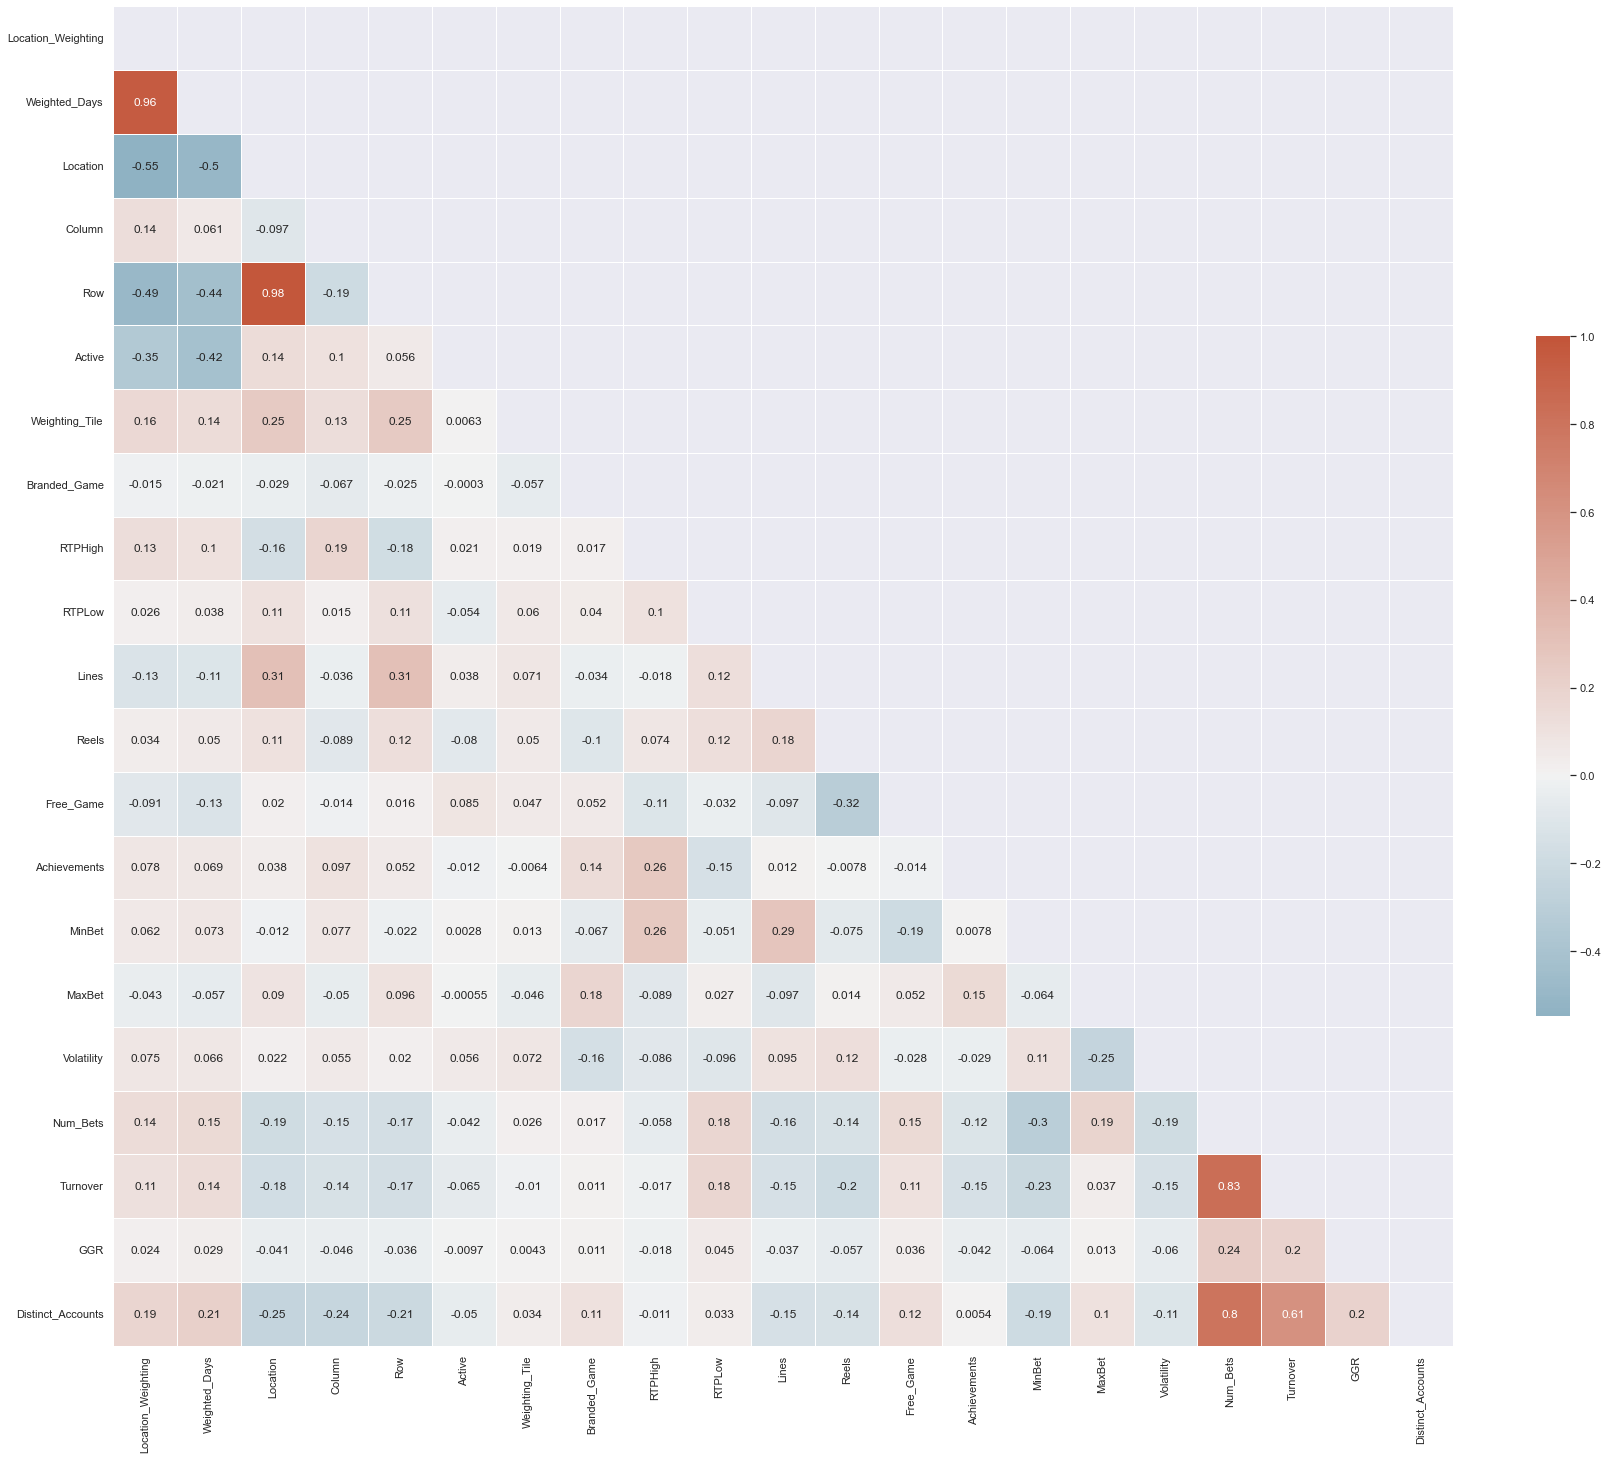

In [1091]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [1092]:
mat['Turnover'].sort_values()

MinBet               -0.225219
Reels                -0.196684
Location             -0.178813
Row                  -0.168516
Volatility           -0.154463
Achievements         -0.153296
Lines                -0.149725
Column               -0.140229
Active               -0.065121
RTPHigh              -0.016637
Weighting_Tile       -0.010340
Branded_Game          0.010873
MaxBet                0.037118
Free_Game             0.107184
Location_Weighting    0.114784
Weighted_Days         0.139886
RTPLow                0.176463
GGR                   0.199098
Distinct_Accounts     0.611304
Num_Bets              0.832634
Turnover              1.000000
Name: Turnover, dtype: float64

##### EDA Target Variable - Turnover 

/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


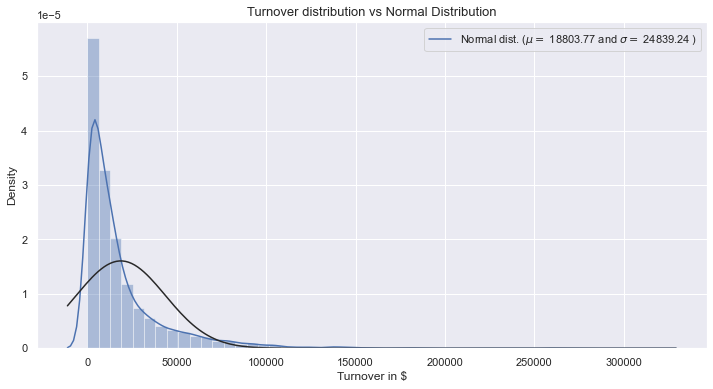

In [1093]:
(mu, sigma) = norm.fit(df['Turnover'])

plt.figure(figsize = (12,6))
sns.distplot(df['Turnover'], kde = True, hist=True, fit = norm)
plt.title('Turnover distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("Turnover in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In [1094]:
print(f"The skewness of the target variable is: {skew(df['Turnover'])}")
print(f"The kurtosis of the target variable is: {kurtosis(df['Turnover'])}")

The skewness of the target variable is: 3.1313844234187598
The kurtosis of the target variable is: 15.866224123506186


Note: Highly skewed, remember to apply log transformation before fitting

##### EDA Categorical Variables

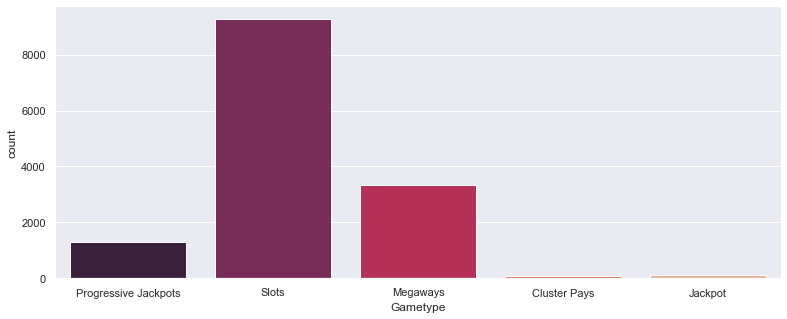

In [1095]:
plt.figure(figsize=(13,5))
ax = sns.countplot(x=df["Gametype"], palette="rocket")

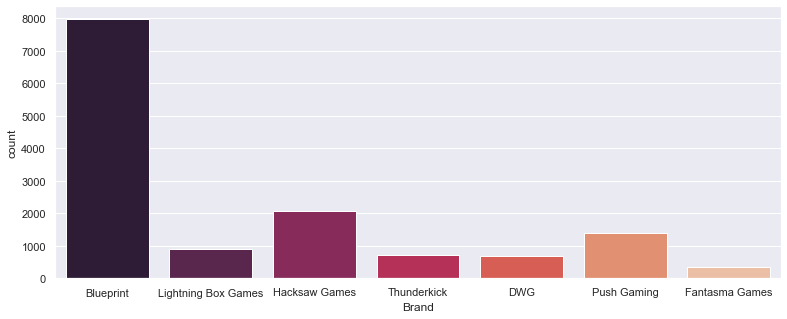

In [1096]:
plt.figure(figsize=(13,5))
ax = sns.countplot(x=df["Brand"], palette="rocket")

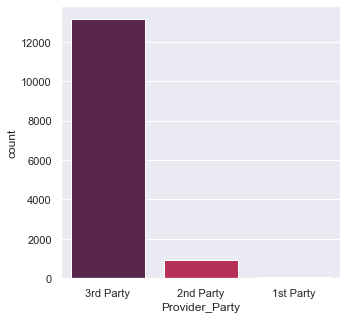

In [1097]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=df["Provider_Party"], palette="rocket")

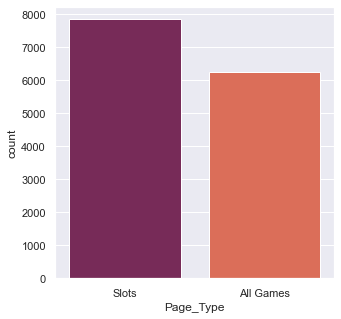

In [1098]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=df["Page_Type"], palette="rocket")

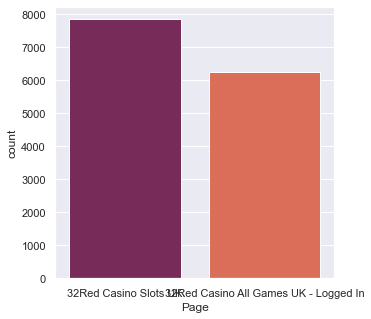

In [1099]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=df["Page"], palette="rocket")

##### EDA Numerical Variables

In [1100]:
num_cols

Index(['Location_Weighting', 'Weighted_Days', 'Location', 'Column', 'Row',
       'Active', 'Weighting_Tile', 'Branded_Game', 'RTPHigh', 'RTPLow',
       'Lines', 'Reels', 'Free_Game', 'Achievements', 'MinBet', 'MaxBet',
       'Volatility', 'Num_Bets', 'Turnover', 'GGR', 'Distinct_Accounts'],
      dtype='object')

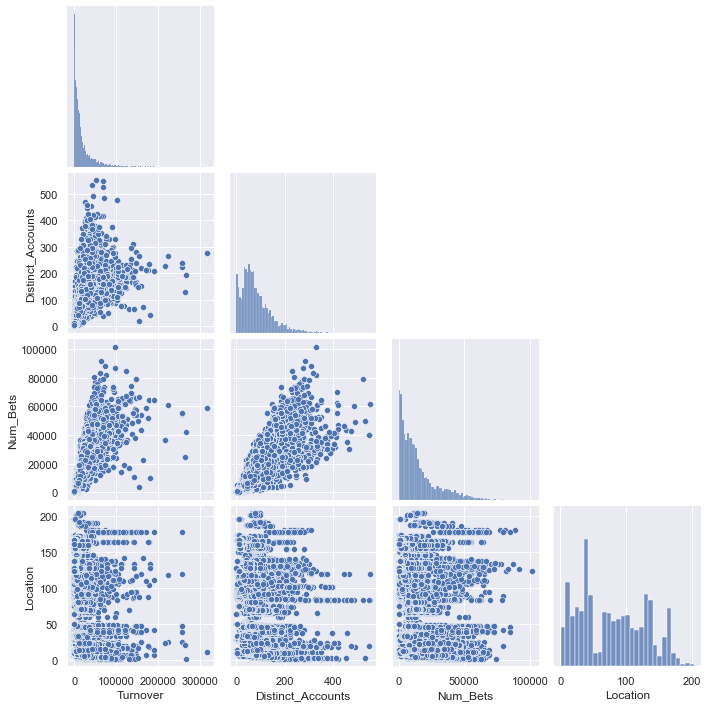

In [1101]:
sns.pairplot(df[['Turnover', 'Distinct_Accounts', 'Num_Bets', 'Location']], corner=True)

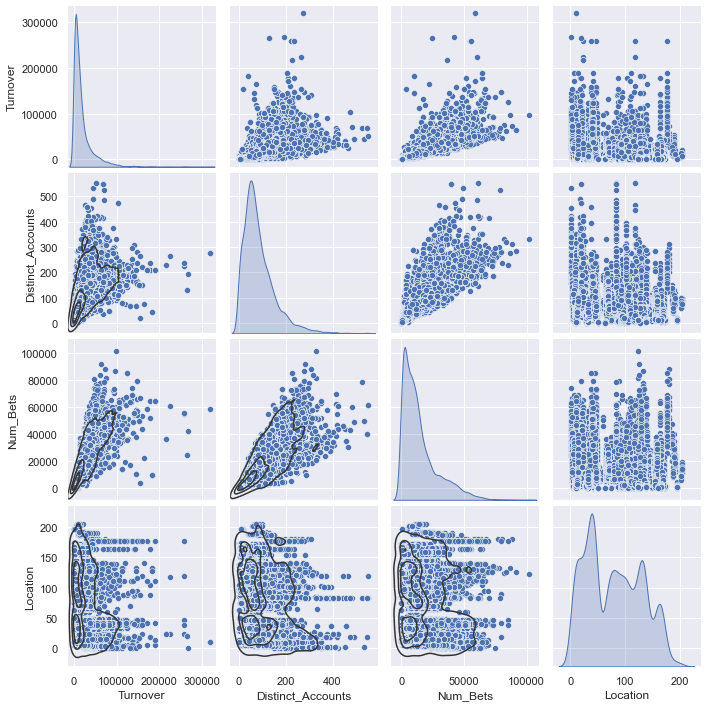

In [1102]:
g = sns.pairplot(df[['Turnover', 'Distinct_Accounts', 'Num_Bets', 'Location']], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

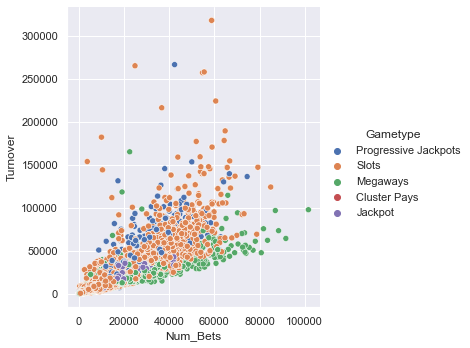

In [1103]:
sns.relplot(data=df, x="Num_Bets", y="Turnover", hue="Gametype")

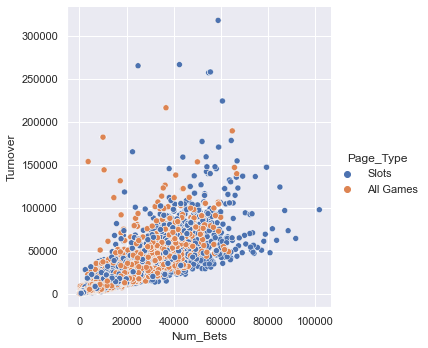

In [1104]:
sns.relplot(data=df, x="Num_Bets", y="Turnover", hue="Page_Type")

##### EDA Positional

Location vs Turnover

[(-1.0, 20.0)]

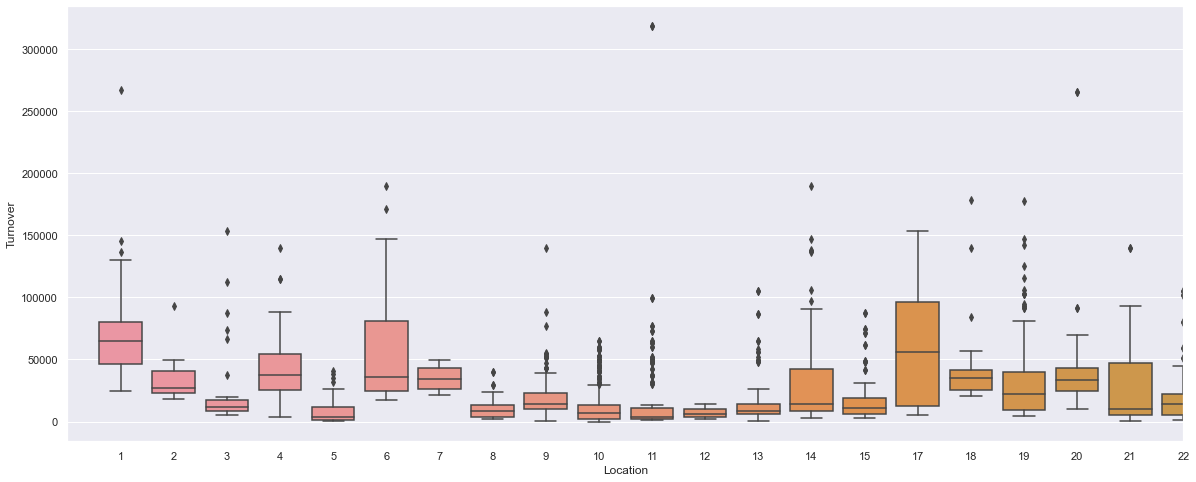

In [1105]:
ax = sns.boxplot(data=df, x="Location", y="Turnover")
ax.set(xlim=(-1, 20))

[(20.0, 40.0)]

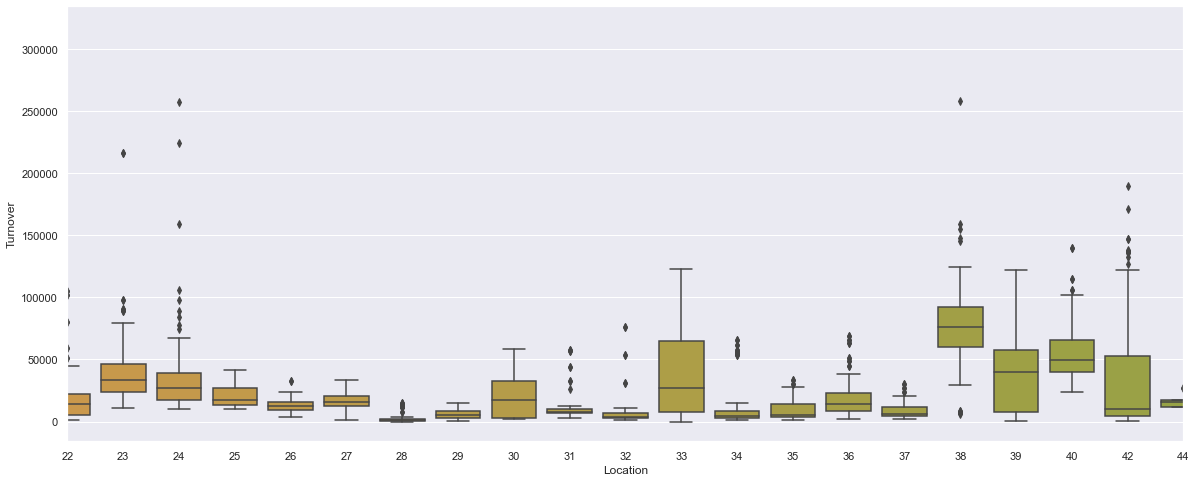

In [1106]:
ax = sns.boxplot(data=df, x="Location", y="Turnover")
ax.set(xlim=(20, 40))

[(40.0, 60.0)]

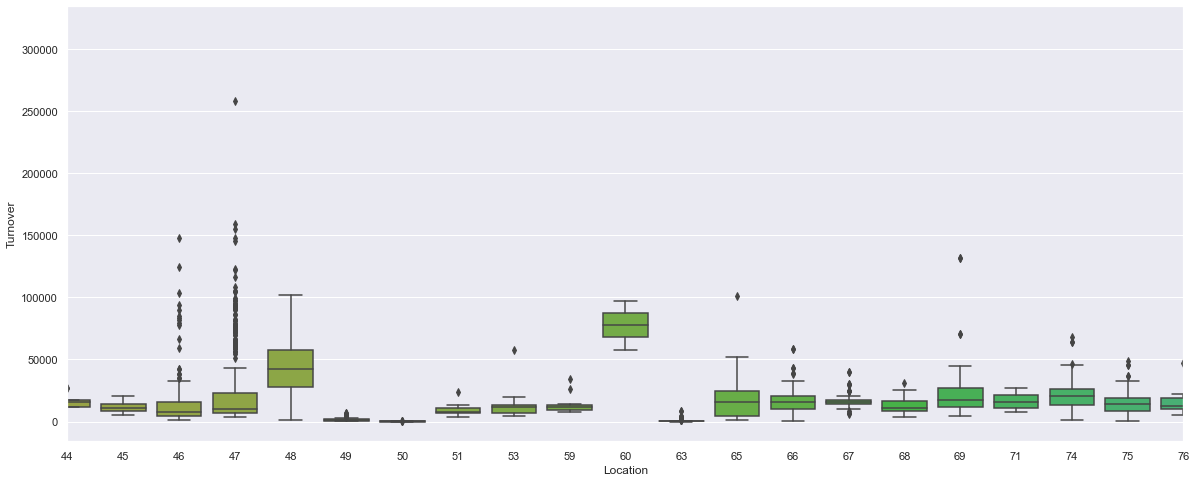

In [1107]:
ax = sns.boxplot(data=df, x="Location", y="Turnover")
ax.set(xlim=(40, 60))

Column placement vs Turnover

<AxesSubplot:xlabel='Column', ylabel='Turnover'>

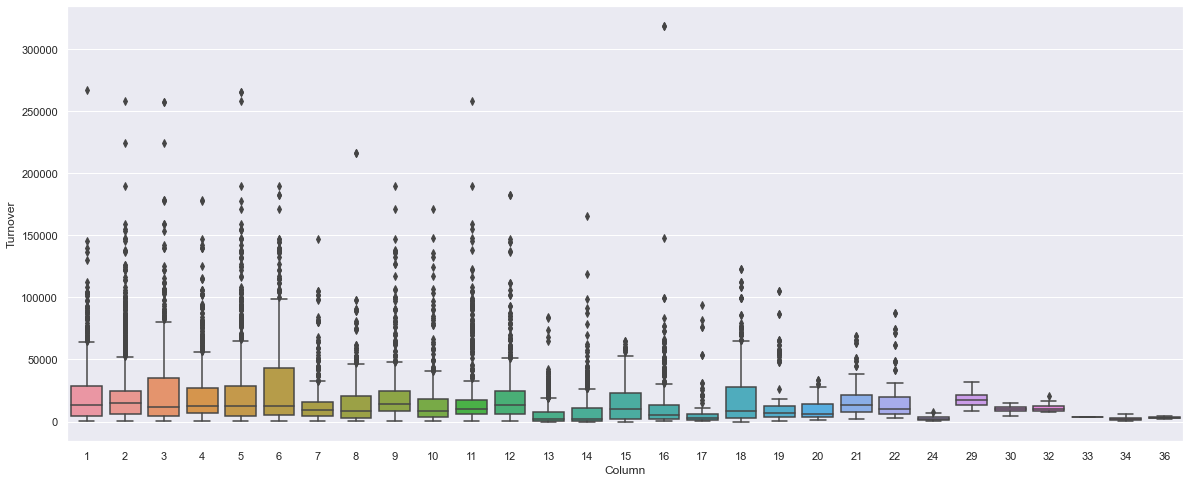

In [1108]:
sns.boxplot(data=df, x="Column", y="Turnover")


Row placement vs Turnover

<AxesSubplot:xlabel='Row', ylabel='Turnover'>

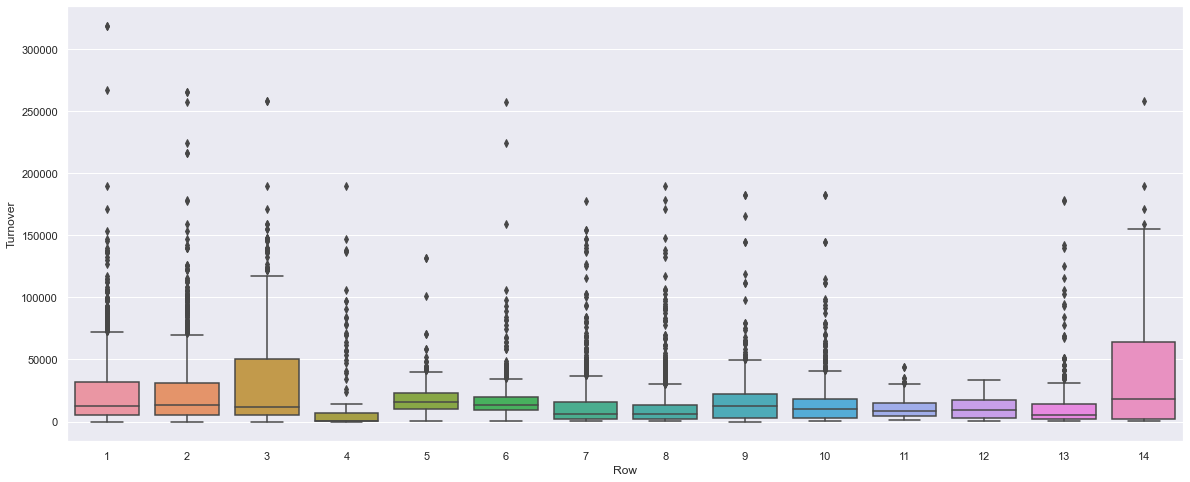

In [1109]:
sns.boxplot(data=df, x="Row", y="Turnover")


Game grid representation with mean turnover

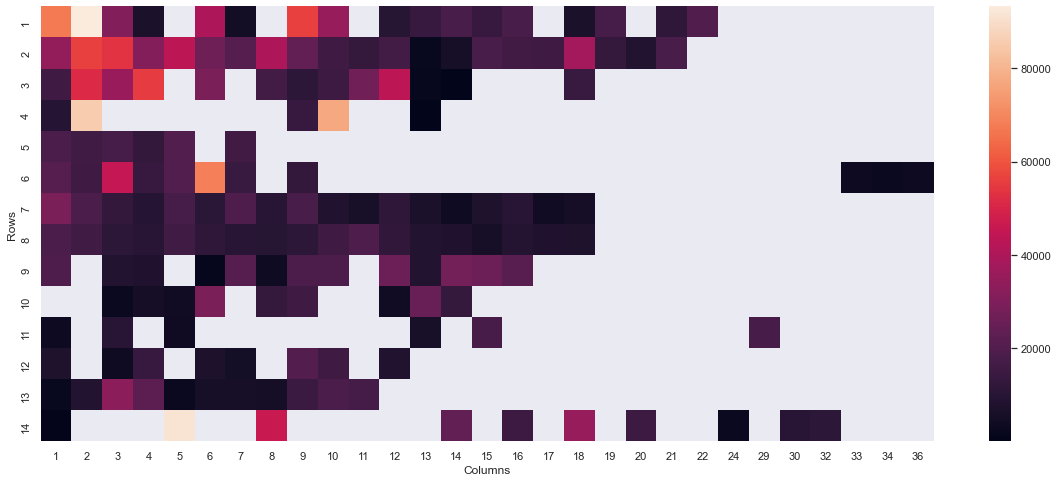

In [1110]:
data = pd.DataFrame({'Columns': df['Column'], 'Rows': df['Row'], 'Turnover': df['Turnover']})
data_pivoted = data.pivot_table(index="Rows",columns= "Columns",values= "Turnover", aggfunc='mean')
ax = sns.heatmap(data_pivoted)
plt.show()

Game grid representation with mean number of bets

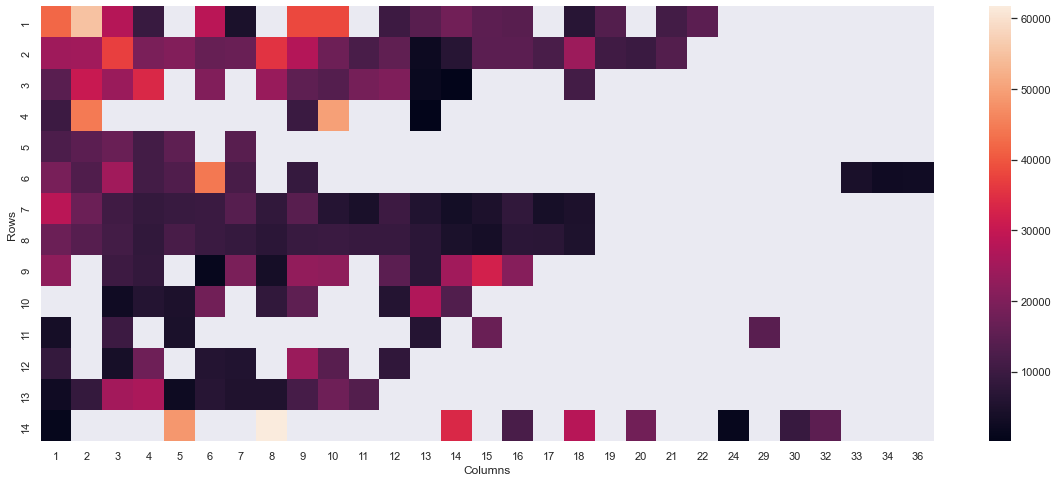

In [1111]:
data = pd.DataFrame({'Columns': df['Column'], 'Rows': df['Row'], 'Num_Bets': df['Num_Bets']})
data_pivoted = data.pivot_table(index="Rows",columns= "Columns",values= "Num_Bets", aggfunc='mean')
ax = sns.heatmap(data_pivoted)
plt.show()

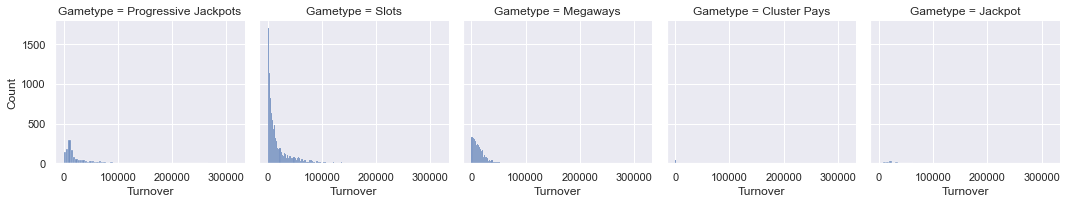

In [1112]:
g = sns.FacetGrid(df, col="Gametype")
g.map(sns.histplot, "Turnover")

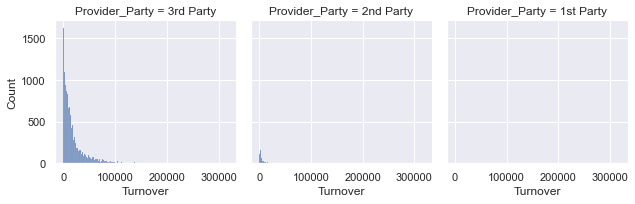

In [1113]:
g = sns.FacetGrid(df, col="Provider_Party")
g.map(sns.histplot, "Turnover")

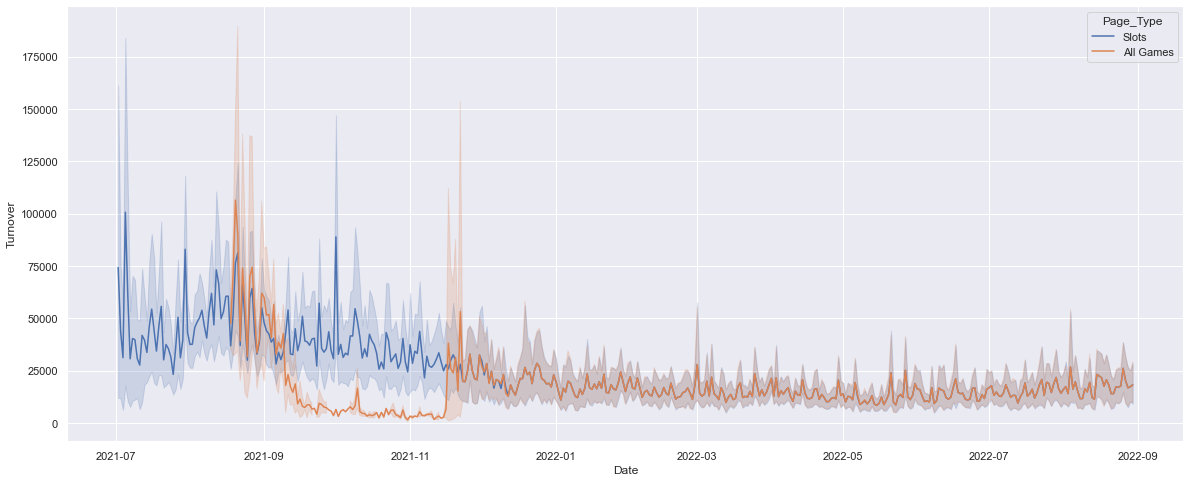

In [1114]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df, x="Date", y="Turnover", hue="Page_Type")

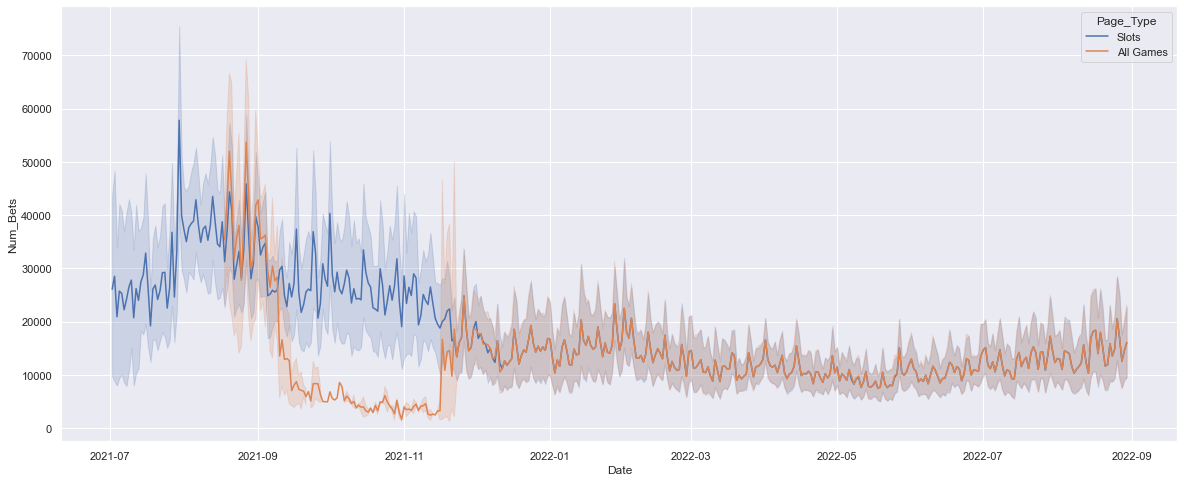

In [1115]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=df, x="Date", y="Num_Bets", hue="Page_Type")

Saving data before preprocessing to easy access it without running all the above code 

In [1116]:
df.to_csv('data/df_preproc.csv', index=False)

### Data Preprocessing

In [16]:
df = pd.read_csv('data/df_preproc.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)
df.head()

,Date,Location_Weighting,Weighted_Days,Location,Column,Row,Active,Weighting_Tile,Game,Brand,...,MaxBet,Volatility,Theme,Page,Page_Type,Num_Bets,Turnover,GGR,Distinct_Accounts,Provider_Party
0,2021-07-02,0.0054,0.3958,69,18,3,0,2,King Kong Cash Jackpot King,Blueprint,...,200.0,3.0,"TV/Film,Cash,Jackpot,King,Kong",32Red Casino Slots UK,Slots,19698.0,32561.82828,328.75260,87.0,3rd Party
1,2021-07-02,0.0182,1.3403,14,14,1,0,1,Rick And Morty - Wubba Lubba Dub,Blueprint,...,500.0,3.0,"TV/Film,Morty",32Red Casino Slots UK,Slots,24407.0,22274.79835,3592.94584,147.0,3rd Party
2,2021-07-02,0.0064,0.4700,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,100.0,5.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,10301.0,11378.50286,746.09485,64.0,3rd Party
3,2021-07-03,0.0064,0.4729,53,2,3,0,2,Eye Of Horus Jackpot King,Blueprint,...,100.0,5.0,"Egypt,Eye,Horus,Jackpot,King",32Red Casino Slots UK,Slots,7729.0,11382.87092,-18685.78886,52.0,3rd Party
4,2021-07-02,0.0063,0.4641,24,3,2,0,1,Fishin Frenzy,Blueprint,...,100.0,3.0,"Fish,Big,Catch,Frenzy",32Red Casino Slots UK,Slots,60594.0,224320.64753,-8472.89533,266.0,3rd Party


In [17]:
df.columns

Index(['Date', 'Location_Weighting', 'Weighted_Days', 'Location', 'Column',
       'Row', 'Active', 'Weighting_Tile', 'Game', 'Brand', 'Gametype',
       'Branded_Game', 'RTPHigh', 'RTPLow', 'Lines', 'Reels', 'Free_Game',
       'Achievements', 'MinBet', 'MaxBet', 'Volatility', 'Theme', 'Page',
       'Page_Type', 'Num_Bets', 'Turnover', 'GGR', 'Distinct_Accounts',
       'Provider_Party'],
      dtype='object')

**Dropping Missed duplicates. For many records we had 2 records with SAME date,game,turnover but totally different POSITIONS, potentially, messing up the potition value in the dataset**

In [18]:
df['RowTimesColumn'] = (df['Column']*df['Row']).astype(int)

In [19]:
df = df.drop_duplicates(subset=['Date','Game'],keep='first')

In [20]:
df = df.sort_values(['Date'], ascending= [True])
df.reset_index(drop=True, inplace=True)

In [21]:
df.to_csv('data/df_original.csv', index=False)

In [22]:
df = pd.read_csv('data/df_original.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

#### Feature Engineering

* Encoding for categorical variables
* Feature Engineering
* Scaling for numerical variables
* Scaling target variable

**Field feature engineering**

In [23]:
# Field Feature Engineering

def assign_to_field(x):
    row = x['Row']
    col = x['Column']
    if (row <= 4) & (col <= 4):
        return "Field_1"
    if (row <= 8) & (col <= 8):
        return "Field_2"
    if (row <= 12) & (col <= 12):
        return "Field_3"
    else:
        return "Field_4"

df['Field'] = df.apply(lambda x: assign_to_field(x), axis=1)
dummies = pd.get_dummies(df['Field'])
df = pd.concat([df.drop(['Field'],axis=1), dummies],axis=1)

**Game Occurence Feature** 

In [24]:
game_occurence = df['Game'].value_counts().rename_axis('Game').reset_index(name='Occurence_Control')
df = pd.merge(df,game_occurence,how='left',on='Game')

**Feature Engineering RTP**

* RTPHigh and RTPLow take the mean of those values and create the RTP as it's a range

In [25]:
df['RTP'] = (df['RTPHigh'] + df['RTPLow'])/2 
df.drop(['RTPHigh', 'RTPLow'], axis=1, inplace=True)

**Date as variable - to incorporate seasonality - and maybe drop weighted_days**

In [26]:
def date_to_year(x):
    # Extract year
    date = x['Date']
    year = "Year_"+str(date.year)
    return year

def date_to_month(x):
    # Extract month
    date = x['Date']
    datetime_object = datetime.datetime.strptime(str(date.month), "%m")
    month = datetime_object.strftime("%B")
    return month 

def date_to_day(x):
    # Extract day 
    date = x['Date']
    datetime_object = datetime.datetime.strptime(str(date.month), "%m")
    day = datetime_object.strftime("%A")
    return day

In [29]:
df['Year'] = df.apply(lambda x: date_to_year(x), axis=1)
df['Month'] = df.apply(lambda x: date_to_month(x), axis=1)
df['Day'] = df.apply(lambda x: date_to_day(x), axis=1)

**Famous games name as feature**
* Not so good results but column and row at top positions of feature importance

In [30]:
# def popular_name(x):
#     occ = x['Occurence_Control']
#     if occ >= 100:
#         return x['Game']
#     else:
#         return "Other"

# df['Popularity_Name'] = df.apply(lambda x: popular_name(x), axis=1)
# dummies = pd.get_dummies(df['Popularity_Name'])
# df = pd.concat([df.drop(['Popularity_Name'],axis=1), dummies],axis=1)

**Performing One hot Encoding on cat variable**

In [32]:
dummies = pd.get_dummies(df[['Brand', 'Gametype','Page', 'Page_Type', 'Provider_Party']])
df = pd.concat([df.drop(['Brand', 'Gametype','Page', 'Page_Type', 'Provider_Party'],axis=1), dummies],axis=1)

**Performing one hot encoding on Year, Month and Day variables**

In [33]:
dummies = pd.get_dummies(df[['Year', 'Month','Day']])
df = pd.concat([df.drop(['Year', 'Month','Day'],axis=1), dummies],axis=1)

**Performing One hot Encoding on Theme variable**

In [34]:
themes_dummies = df['Theme'].str.get_dummies(sep=",")
themes_dummies.columns = themes_dummies.columns.map(lambda x: 'Theme_' + str(x))
df = pd.concat([df.drop(['Theme'],axis=1), themes_dummies],axis=1)

Scaling numerical variables

* Lines
* Reels
* RTP

In [35]:
scaler = StandardScaler()

numerical_cols = ['RTP', 'Lines', 'Reels']
df_scaled = scaler.fit_transform(df[numerical_cols])
df[numerical_cols] = df_scaled

**Dropping highly correlated with turnover variables**

In [36]:
df.drop(['Num_Bets','GGR','Distinct_Accounts','RowTimesColumn'], axis=1, inplace=True)

**Save all feature engineering to new csv**

In [37]:
df.to_csv('data/df_original_model_clean.csv', index=False)

**Comments on the above**

* Date engineering, with location and with Weighted days does the least MAError. 
* Without Weighted Days and Location Weighting, feature importance shows Column and Row at top positions

### Data Modelling

##### Ingesting data ready for modelling

In [38]:
df = pd.read_csv('data/df_original_model_clean.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Location'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1994)

print(f"X_train dims: {X_train.shape} \ny_train dims: {y_train.shape} \nX_test dims: {X_test.shape} \ny_test dims: {y_test.shape}")

X_train dims: (6013, 172) 
y_train dims: (6013,) 
X_test dims: (669, 172) 
y_test dims: (669,)


##### Dummy regressor to establish baseline 

In [39]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

pred = dummy_regr.predict(X_train)

print(f"The RMSE score for the baseline dummy is: {mse(y_train, pred):.2f}")

The RMSE score for the baseline dummy is: 547984557.86


Linear Regression

In [41]:
reg = LinearRegression().fit(X_train, y_train)
preds = reg.predict(X_train)
print(f"MAE on training data is: {mean_absolute_error(y_train, preds):.2f}")

MAE on training data is: 6953.72


CatBoostRegressor

In [42]:
reg = CatBoostRegressor().fit(X_train, y_train, verbose=0)
preds = reg.predict(X_train)
print(f"MAE on training data is: {mean_absolute_error(y_train, preds):.2f}")

MAE on training data is: 5039.89


XGBoost Regressor

In [43]:
reg = XGBRegressor().fit(X_train, y_train)
preds = reg.predict(X_train)
print(f"MAE on training data is: {mean_absolute_error(y_train, preds):.2f}")

MAE on training data is: 3778.82


##### Estimators for stack regressor

* Ridge - πολυσυγγραμικότητα
* SVG
* XGBoost
* Huber 
* CatBoostRegressor 

In [1206]:
# ridge 
ridgemodel = Ridge(alpha=26)

# xgbmodel
xgbmodel = XGBRegressor(objective='reg:squarederror', 
                        n_estimators=1000, 
                        learning_rate=0.02)

# SVR 
svrmodel = SVR(C=8, 
               epsilon=0.00005, 
               gamma=0.0008)

# Huber 
hubermodel = HuberRegressor(alpha=30,
                            epsilon=3,
                            fit_intercept=True,
                            max_iter=2000)

# CatBoost
cbmodel = cb.CatBoostRegressor(loss_function='RMSE',
                               colsample_bylevel=0.3, 
                               depth=2,
                               l2_leaf_reg=20, 
                               learning_rate=0.005, 
                               n_estimators=15000, 
                               subsample=0.3,
                               verbose=False)

##### Stacking

In [1207]:
estimators = [('ridgemodel', Ridge(alpha=26)), 
              ('svrmodel', SVR(C=8, epsilon=0.00005, gamma=0.0008)), 
              ('hubermodel', HuberRegressor(alpha=30,epsilon=3,fit_intercept=True,max_iter=10000)), 
              ('cbmodel', cb.CatBoostRegressor(loss_function='RMSE',colsample_bylevel=0.3, depth=2,
                          l2_leaf_reg=20, learning_rate=0.005, n_estimators=15000, subsample=0.3,verbose=False))]

stackmodel = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.02))

In [1208]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test,fit)))

-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2601
Test RMSE: 0.2641
-----------------------------


/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.2587
Test RMSE: 0.2625
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.145
Test RMSE: 0.155
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.2307
Test RMSE: 0.2376
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='a

In [1212]:
final_prediction = (3 * xgbmodel.predict(X_test) \
+  5 * stackmodel.predict(X_test) + 3 * cbmodel.predict(X_test)) / 11

print(f"Test RMSE for ensemble model: \n{round(math.sqrt(mse(y_test_log,final_prediction)), 4)}")

Test RMSE for ensemble model: 
0.1395


#### Forensic analysis - Error analysis

In [44]:
record_id = y_train.index
abs_margin_of_error = np.abs(y_train - preds)
margin_of_error = y_train - preds
perc_of_error = (np.abs(y_train - preds) / y_train) * 100

err_anal_df = pd.DataFrame(list(zip(y_train, preds, margin_of_error, perc_of_error, abs_margin_of_error)),
                          columns=['Turnover','Predicted Turnover','MAE', 'Percentage of Error', 'AbsMAE'], 
                          index=record_id)

err_anal_df

,Turnover,Predicted Turnover,MAE,Percentage of Error,AbsMAE
6448,5674.99802,6300.309082,-625.311062,11.018701,625.311062
3050,12384.97617,11611.265625,773.710545,6.247170,773.710545
6043,24109.13506,26346.876953,-2237.741893,9.281718,2237.741893
1880,1991.55516,1370.086914,621.468246,31.205174,621.468246
6156,12396.33038,9246.885742,3149.444638,25.406266,3149.444638
...,...,...,...,...,...
4432,12048.21949,13305.643555,-1257.424065,10.436597,1257.424065
203,42623.24880,44546.203125,-1922.954325,4.511515,1922.954325
2082,5138.03335,9817.074219,-4679.040869,91.066767,4679.040869
3427,3505.72619,10698.439453,-7192.713263,205.170423,7192.713263


/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


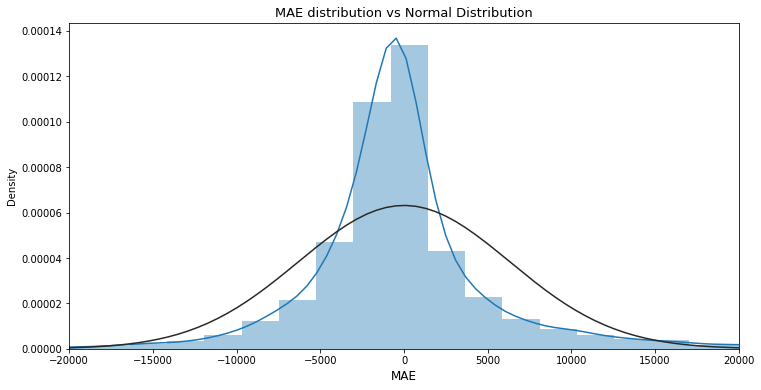

In [45]:
(mu, sigma) = norm.fit(err_anal_df['MAE'])

plt.figure(figsize = (12,6))
sns.distplot(err_anal_df['MAE'], kde = True, hist=True, fit = norm)
plt.title('MAE distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("MAE", fontsize = 12)
plt.xlim((-20000, 20000))  

plt.show()

Those are records that have a huge margin or error, highly disproportionate to the real values being 49000 times more that the real value. Those errors mess up the MAE in the first place and makes us wonder why the predictor estimates those so wrong. Let's do a forensic analysis on those values.

In [46]:
err_anal_df['Percentage of Error'].sort_values(ascending=False)[0:10]

2291    122780.519896
4227     67073.285055
1858     30352.907695
6410     25215.919867
1991     19809.241794
3076     18782.586867
6572     11207.693122
3807     10770.051682
6267      9676.696917
5335      9368.494355
Name: Percentage of Error, dtype: float64

In general, maybe we should remove records with very low turnover < 50 and run the experiments again as those can be either errors, or test cases

In [47]:
err_anal_df.loc[4807] # UNDERESTIMATED

Turnover               4100.648440
Predicted Turnover     9933.208984
MAE                   -5832.560544
Percentage of Error     142.235079
AbsMAE                 5832.560544
Name: 4807, dtype: float64

In [48]:
err_anal_df.loc[4654] # OVERESTIMATED

Turnover               13584.085550
Predicted Turnover     12416.010742
MAE                     1168.074808
Percentage of Error        8.598848
AbsMAE                  1168.074808
Name: 4654, dtype: float64

When looking at the records with very high MAE, we see that their actual turnover was very high compared to the dataset. The percentage of error is not that bad, but because of their very high turnover, a normal percentage of error can through us out of the MAE by 50k - 100k which is messing our numbers

Bin Mae

In [49]:
def calc_bin_mae(bin_test):
    test_1 = bin_test[bin_test['Turnover']<=5000]
    y_test_1 = test_1['Turnover']
    X_test_1 = test_1.drop(columns=['Turnover'])
    preds = reg.predict(X_test_1)
    print(f"MAE on test data 1 [0,5000] Turnover is: {mean_absolute_error(y_test_1, preds):.2f}")

    test_2 = bin_test[(bin_test['Turnover']>5000) & (bin_test['Turnover']<=10000)]
    y_test_2 = test_2['Turnover']
    X_test_2 = test_2.drop(columns=['Turnover'])
    preds = reg.predict(X_test_2)
    print(f"MAE on test data 2 [5000,10000] Turnover is: {mean_absolute_error(y_test_2, preds):.2f}")

    test_3 = bin_test[(bin_test['Turnover']>10000) & (bin_test['Turnover']<=15000)]
    y_test_3 = test_3['Turnover']
    X_test_3 = test_3.drop(columns=['Turnover'])
    preds = reg.predict(X_test_3)
    print(f"MAE on test data 3 [10000,15000] Turnover is: {mean_absolute_error(y_test_3, preds):.2f}")

    test_4 = bin_test[(bin_test['Turnover']>15000) & (bin_test['Turnover']<=25000)]
    y_test_4 = test_4['Turnover']
    X_test_4 = test_4.drop(columns=['Turnover'])
    preds = reg.predict(X_test_4)
    print(f"MAE on test data 4 [15000,25000] Turnover is: {mean_absolute_error(y_test_4, preds):.2f}")

    test_5 = bin_test[(bin_test['Turnover']>25000) & (bin_test['Turnover']<=35000)]
    y_test_5 = test_5['Turnover']
    X_test_5 = test_5.drop(columns=['Turnover'])
    preds = reg.predict(X_test_5)
    print(f"MAE on test data 5 [25000,35000] Turnover is: {mean_absolute_error(y_test_5, preds):.2f}")

    test_6 = bin_test[bin_test['Turnover']>35000]
    y_test_6 = test_6['Turnover']
    X_test_6 = test_6.drop(columns=['Turnover'])
    preds = reg.predict(X_test_6)
    print(f"MAE on test data 6 [35000,+] Turnover is: {mean_absolute_error(y_test_6, preds):.2f}")

In [50]:
bin_test = pd.concat([X_test, y_test], axis=1)
calc_bin_mae(bin_test)

MAE on test data 1 [0,5000] Turnover is: 1643.41
MAE on test data 2 [5000,10000] Turnover is: 3189.06
MAE on test data 3 [10000,15000] Turnover is: 4304.64
MAE on test data 4 [15000,25000] Turnover is: 6663.23
MAE on test data 5 [25000,35000] Turnover is: 8849.69
MAE on test data 6 [35000,+] Turnover is: 17009.41


#### XGBoost Parameter Tuning

In [52]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor(eval_metric="mae")
hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

xgb_grid = GridSearchCV(xgb1,
                        hyperparameter_grid,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
0.699776985882939
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 800}


In [53]:
preds = xgb_grid.predict(X_test)
print(f"MAE on test data is: {mean_absolute_error(y_test, preds):.2f}")

MAE on test data is: 5995.06


The default values of XGBoost scored about the same as the grid search hyperparameter tuning.

##### Modelling WITHOUT position data

In [1219]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Location', 'Row', 'Column', 'Location_Weighting'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [1220]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train_log)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train_log,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test_log,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test_log,fit)))
print("-----------------------------")

final_prediction = (3 * xgbmodel.predict(X_test) \
+  5 * stackmodel.predict(X_test) + 3 * cbmodel.predict(X_test)) / 11

print(f"Test RMSE for ensemble model: \n{round(math.sqrt(mse(y_test_log,final_prediction)), 4)}")

predictions = np.array(10**final_prediction)

pred_df = pd.DataFrame({'Predictions No Location':predictions})


-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2616
Test RMSE: 0.2659
-----------------------------


/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.256
Test RMSE: 0.2598
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.1449
Test RMSE: 0.1549
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.2465
Test RMSE: 0.2495
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='

##### Result table

| Algorithm           | Train RMSE              | Test RMSE |    
| :---                |    :----:               |  :----:     |
| Baseline Dummy Mean Regressor | 0.4786             |   0.4786      |
| HuberRegressor      | 0.2625                  |   0.2587  |
| CatBoostRegressor   | 0.1551                   |  0.1451  |
| SVR                 | 0.2376                  |   0.2307  |
| **XGBRegressor**        | **0.1203**          |   **0.0942**  |
| StackingRegressor   | 0.1533                  |   0.1361   |
| TabNet              | 0.1604                  |   0.1544  |
| Blend               | 0.1395                  |   0.1419   |


Estimating number of bets with position data

In [1236]:
X = df.drop(columns=['Num_Bets', 'Date', 'Game'])
y = df['Num_Bets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

In [1237]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test,fit)))
print("-----------------------------")

final_prediction = (3 * xgbmodel.predict(X_test) \
+  5 * stackmodel.predict(X_test) + 3 * cbmodel.predict(X_test)) / 11

print(f"Test RMSE for ensemble model: \n{round(math.sqrt(mse(y_test,final_prediction)), 4)}")

predictions = np.array(10**final_prediction)

pred_df = pd.DataFrame({'Predictions No Location':predictions})


-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2769
Test RMSE: 0.2823
-----------------------------
For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.3488
Test RMSE: 0.3602
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.1968
Test RMSE: 0.2055
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.0257
Test RMSE: 0.5379
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delt

Estimating number of bets without position data

In [1234]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Num_Bets', 'Date', 'Game', 'Location', 'Row', 'Column', 'Location_Weighting'])
y = df['Num_Bets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

In [1235]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test,fit)))
print("-----------------------------")

final_prediction = (3 * xgbmodel.predict(X_test) \
+  5 * stackmodel.predict(X_test) + 3 * cbmodel.predict(X_test)) / 11

print(f"Test RMSE for ensemble model: \n{round(math.sqrt(mse(y_test,final_prediction)), 4)}")

predictions = np.array(10**final_prediction)

pred_df = pd.DataFrame({'Predictions No Location':predictions})


-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2785
Test RMSE: 0.2837
-----------------------------
For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.3286
Test RMSE: 0.3459
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.2008
Test RMSE: 0.2095
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.0892
Test RMSE: 0.4129
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delt

Number of bets

| Algorithm           | RMSE WITH LOCATION DATA | RMSE WITHOUT LOCATION DATA |
| :---                |    :----:               |          ---:              |
| Blend               | **0.1644**                  | 0.1709                     |


#### Model explainability

In [10]:
# Getting the data ready to feed to the network
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=1994)

In [12]:
from sklearn.metrics import mean_absolute_error

In [14]:
regressor = TabNetRegressor(verbose=1,seed=42)
regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=50, max_epochs=2000,
              eval_metric=['mae'])

preds = regressor.predict(X_test)
print(f"TabNet Regressor MAE: \n{mean_absolute_error(y_test,preds):.2f}")

Device used : cpu
epoch 0  | loss: 938198554.96855| val_0_mae: 18508.35833|  0:00:00s
epoch 1  | loss: 938093035.06918| val_0_mae: 18506.52172|  0:00:01s
epoch 2  | loss: 937886075.57233| val_0_mae: 18502.68526|  0:00:02s
epoch 3  | loss: 937455285.53459| val_0_mae: 18495.79918|  0:00:03s
epoch 4  | loss: 936661520.10063| val_0_mae: 18479.79268|  0:00:04s
epoch 5  | loss: 935527146.26415| val_0_mae: 18464.43077|  0:00:05s
epoch 6  | loss: 934097089.61006| val_0_mae: 18433.63964|  0:00:06s
epoch 7  | loss: 932291776.0| val_0_mae: 18416.06412|  0:00:07s
epoch 8  | loss: 930138087.04403| val_0_mae: 18405.12506|  0:00:08s
epoch 9  | loss: 927708856.3522| val_0_mae: 18382.20155|  0:00:09s
epoch 10 | loss: 924890193.71069| val_0_mae: 18317.47962|  0:00:10s
epoch 11 | loss: 921557537.00629| val_0_mae: 18277.07278|  0:00:11s
epoch 12 | loss: 917787785.25786| val_0_mae: 18229.36924|  0:00:12s
epoch 13 | loss: 913207290.36478| val_0_mae: 18133.14809|  0:00:13s
epoch 14 | loss: 908390407.24528| v

In [1271]:
explainability_matrix , masks = regressor.explain(X_valid)

# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
val_preds = regressor.predict(X_valid)

explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])

Feature Importance

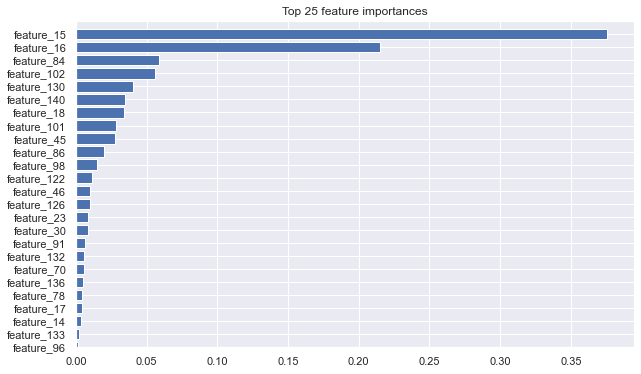

In [1273]:
feat_importances = regressor.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Top 25 feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
features = ['feature_{}'.format(i) for i in range(0, 150)]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
# all features
# plt.ylim([-1, len(feat_importances)])
# Top 25 features
plt.ylim([len(feat_importances)-25, len(feat_importances)])
plt.show();

In [1295]:
# Top 25 features 

cols = [15,16,84,102,130,140,18,101,45,86,98,122]
print(X.columns[cols])

Index(['Num_Bets', 'GGR', 'Theme_Hawaiian', 'Theme_Luck', 'Theme_Thai',
       'Theme_Wild West', 'Brand_DWG', 'Theme_Lost', 'Theme_Bonanza',
       'Theme_Horror', 'Theme_Lava', 'Theme_Sea'],
      dtype='object')


##### Looking at the explainability of the TabNet, I am wondering whether the regressor was relying only on Num_Bets and GGR and that's why location data did not play an important role regarding the decision. I will take those two columns out, and run the experiment again to see if anything changes.

With position data

In [1299]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Num_Bets', 'GGR'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [1300]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train_log)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train_log,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test_log,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test_log,fit)))

-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2699
Test RMSE: 0.2713
-----------------------------


/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.2684
Test RMSE: 0.2701
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.2208
Test RMSE: 0.2321
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.2499
Test RMSE: 0.2539
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor=

Without Position data

In [1301]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Num_Bets', 'GGR', 'Location', 'Row', 'Column', 'Location_Weighting'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [1302]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train, y_train_log)

    print(f"For model {i}")
    print(f"Train RMSE: {round(math.sqrt(mse(y_train_log,i.predict(X_train))), 4)}")
    print(f"Test RMSE: {round(math.sqrt(mse(y_test_log,i.predict(X_test))), 4)}")
    print("-----------------------------")
print("-----------------------------")
print("Average Test RMSE for ensemble model: ")
fit = (svrmodel.predict(X_test) + xgbmodel.predict(X_test) + stackmodel.predict(X_test) + ridgemodel.predict(X_test) + hubermodel.predict(X_test) + cbmodel.predict(X_test)) / 6
print(math.sqrt(mse(y_test_log,fit)))

-----------------------------
Overview of model performance
-----------------------------
For model Ridge(alpha=26)
Train RMSE: 0.2705
Test RMSE: 0.2721
-----------------------------


/Users/andreas/opt/anaconda3/envs/regression_tech/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


For model HuberRegressor(alpha=30, epsilon=3, max_iter=2000)
Train RMSE: 0.2647
Test RMSE: 0.2666
-----------------------------
For model <catboost.core.CatBoostRegressor object at 0x8f351b4f0>
Train RMSE: 0.2217
Test RMSE: 0.2333
-----------------------------
For model SVR(C=8, epsilon=5e-05, gamma=0.0008)
Train RMSE: 0.2673
Test RMSE: 0.2702
-----------------------------
For model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor=

In [1312]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Num_Bets', 'GGR'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

In [1304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=1994)
y_train_log = np.log10(y_train)
y_valid_log = np.log10(y_valid)

regressor = TabNetRegressor(verbose=1,seed=42)
regressor.fit(X_train=X_train, y_train=y_train_log,
              eval_set=[(X_valid, y_valid_log)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])

preds = regressor.predict(X_test)
print(f"TabNet Regressor RMSE: \n{round(math.sqrt(mse(y_test_log,preds)), 4)}")

Device used : cpu
epoch 0  | loss: 9.25727 | val_0_rmse: 1.77766 |  0:00:00s
epoch 1  | loss: 1.39006 | val_0_rmse: 1.4718  |  0:00:01s
epoch 2  | loss: 0.4809  | val_0_rmse: 0.81489 |  0:00:02s
epoch 3  | loss: 0.26222 | val_0_rmse: 0.65826 |  0:00:03s
epoch 4  | loss: 0.2147  | val_0_rmse: 0.51447 |  0:00:04s
epoch 5  | loss: 0.1736  | val_0_rmse: 0.44896 |  0:00:05s
epoch 6  | loss: 0.15415 | val_0_rmse: 0.37496 |  0:00:06s
epoch 7  | loss: 0.13549 | val_0_rmse: 0.36002 |  0:00:07s
epoch 8  | loss: 0.11877 | val_0_rmse: 0.3513  |  0:00:08s
epoch 9  | loss: 0.10969 | val_0_rmse: 0.32797 |  0:00:09s
epoch 10 | loss: 0.10059 | val_0_rmse: 0.32918 |  0:00:10s
epoch 11 | loss: 0.09648 | val_0_rmse: 0.31957 |  0:00:11s
epoch 12 | loss: 0.08849 | val_0_rmse: 0.33164 |  0:00:12s
epoch 13 | loss: 0.08713 | val_0_rmse: 0.33651 |  0:00:13s
epoch 14 | loss: 0.08533 | val_0_rmse: 0.33307 |  0:00:14s
epoch 15 | loss: 0.08371 | val_0_rmse: 0.32695 |  0:00:15s
epoch 16 | loss: 0.07772 | val_0_rmse:

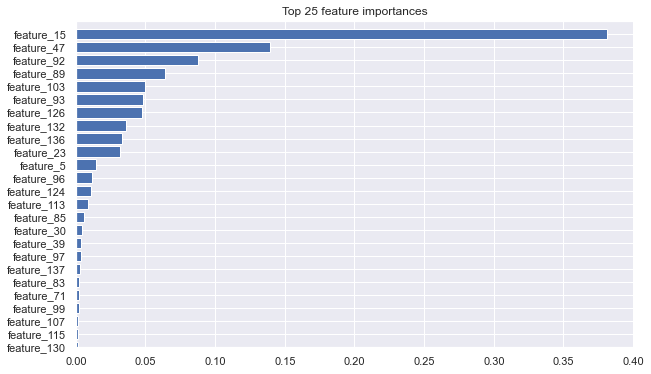

In [1305]:
explainability_matrix , masks = regressor.explain(X_valid)

# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
val_preds = regressor.predict(X_valid)

explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])

feat_importances = regressor.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Top 25 feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
features = ['feature_{}'.format(i) for i in range(0, 150)]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
# all features
# plt.ylim([-1, len(feat_importances)])
# Top 25 features
plt.ylim([len(feat_importances)-25, len(feat_importances)])
plt.show();

In [1313]:
# Top 25 features 

cols = [15,47,92,89,103,93,126,132,136]
print(X.columns[cols])

Index(['Distinct_Accounts', 'Theme_Chaos', 'Theme_Jungle', 'Theme_Japanese',
       'Theme_Mexican', 'Theme_King', 'Theme_Sync', 'Theme_Voltage',
       'Theme_Weather'],
      dtype='object')


TabNet without position data

In [1314]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game', 'Num_Bets', 'GGR', 'Location', 'Row', 'Column', 'Location_Weighting'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

In [1307]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=1994)
y_train_log = np.log10(y_train)
y_valid_log = np.log10(y_valid)

regressor = TabNetRegressor(verbose=1,seed=42)
regressor.fit(X_train=X_train, y_train=y_train_log,
              eval_set=[(X_valid, y_valid_log)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])

preds = regressor.predict(X_test)
print(f"TabNet Regressor RMSE: \n{round(math.sqrt(mse(y_test_log,preds)), 4)}")

Device used : cpu
epoch 0  | loss: 12.69751| val_0_rmse: 2.41064 |  0:00:01s
epoch 1  | loss: 2.14965 | val_0_rmse: 0.76963 |  0:00:01s
epoch 2  | loss: 0.64294 | val_0_rmse: 0.74225 |  0:00:02s
epoch 3  | loss: 0.40705 | val_0_rmse: 0.69644 |  0:00:03s
epoch 4  | loss: 0.29851 | val_0_rmse: 0.64663 |  0:00:04s
epoch 5  | loss: 0.19046 | val_0_rmse: 0.63742 |  0:00:05s
epoch 6  | loss: 0.14561 | val_0_rmse: 0.58934 |  0:00:06s
epoch 7  | loss: 0.12817 | val_0_rmse: 0.56284 |  0:00:07s
epoch 8  | loss: 0.11546 | val_0_rmse: 0.55371 |  0:00:08s
epoch 9  | loss: 0.10912 | val_0_rmse: 0.51439 |  0:00:09s
epoch 10 | loss: 0.10197 | val_0_rmse: 0.49531 |  0:00:10s
epoch 11 | loss: 0.09716 | val_0_rmse: 0.50132 |  0:00:11s
epoch 12 | loss: 0.09443 | val_0_rmse: 0.48139 |  0:00:12s
epoch 13 | loss: 0.09239 | val_0_rmse: 0.47214 |  0:00:13s
epoch 14 | loss: 0.09172 | val_0_rmse: 0.46726 |  0:00:14s
epoch 15 | loss: 0.08829 | val_0_rmse: 0.47679 |  0:00:15s
epoch 16 | loss: 0.08965 | val_0_rmse:

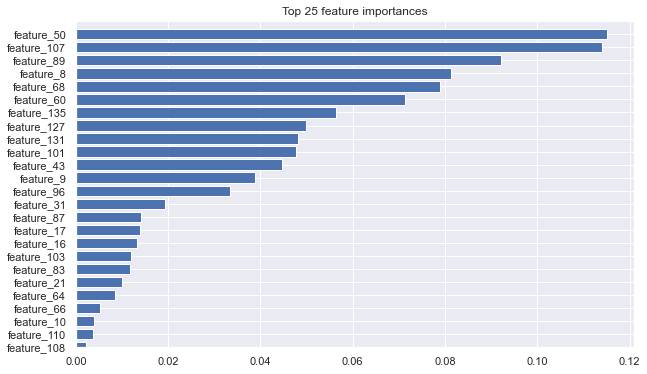

In [1308]:
explainability_matrix , masks = regressor.explain(X_valid)

# Normalize the importance by sample
normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
val_preds = regressor.predict(X_valid)

explain_and_preds = np.hstack([normalized_explain_mat, val_preds.reshape(-1, 1)])

feat_importances = regressor.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Top 25 feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
features = ['feature_{}'.format(i) for i in range(0, 150)]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
# all features
# plt.ylim([-1, len(feat_importances)])
# Top 25 features
plt.ylim([len(feat_importances)-25, len(feat_importances)])
plt.show();

In [1315]:
# Top 25 features 

cols = [50,107,89,8,68,60,135,127,131,101,43,9]
print(X.columns[cols])

Index(['Theme_Dead', 'Theme_Ra', 'Theme_King', 'MinBet', 'Theme_Gems',
       'Theme_Fish', 'Theme_Win', 'Theme_Volcanoes', 'Theme_Ways',
       'Theme_Money/Treasure/Jewelry', 'Theme_Chaos', 'MaxBet'],
      dtype='object')


##### Linear Regression top coeff

In [1337]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game'])
y = df['Turnover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [1338]:
reg = LinearRegression().fit(X_train, y_train_log)
reg.score(X_train, y_train_log)

0.8585628794460377

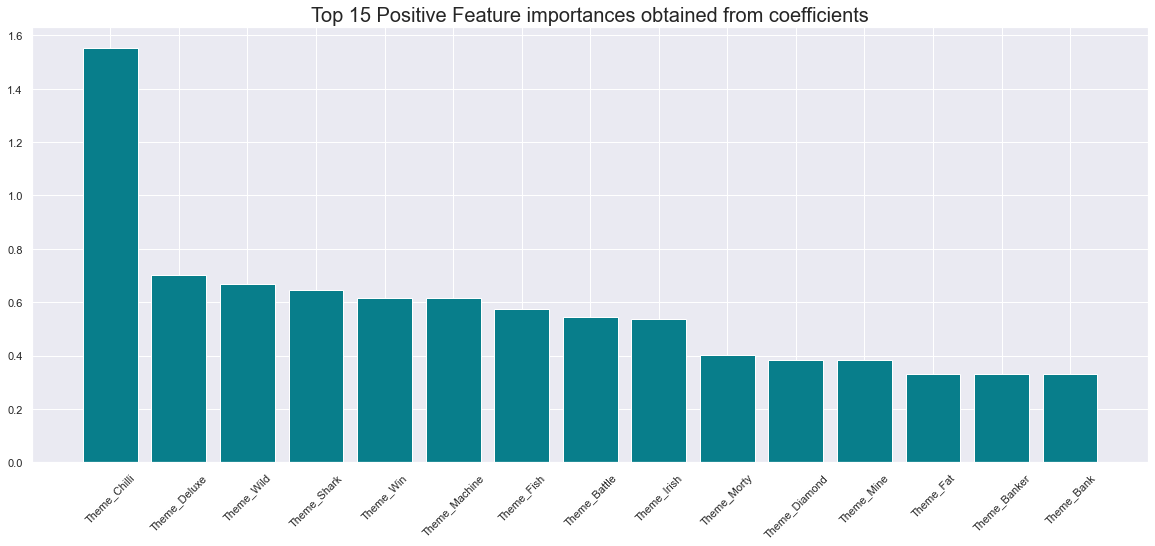

In [1345]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': reg.coef_
})

importances = importances.sort_values(by='Importance', ascending=False)
importances = importances[:15]

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Top 15 Positive Feature importances obtained from coefficients', size=20)
plt.xticks(rotation=45)
plt.show()

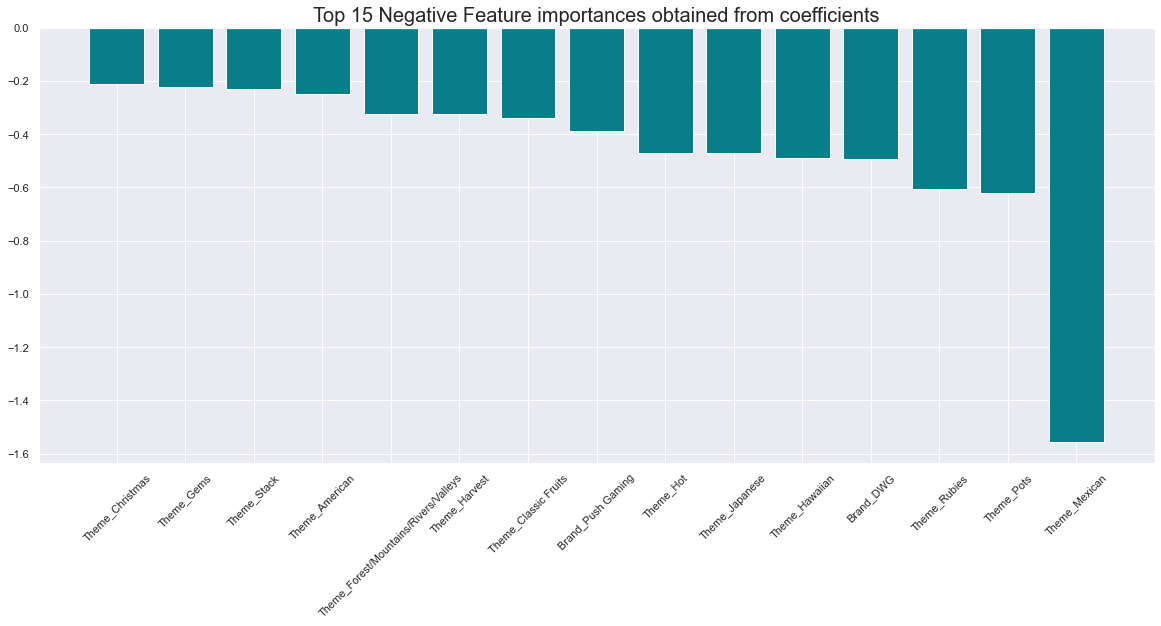

In [1344]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': reg.coef_
})

importances = importances.sort_values(by='Importance', ascending=False)
importances = importances[-15:]

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Top 15 Negative Feature importances obtained from coefficients', size=20)
plt.xticks(rotation=45)
plt.show()

Experiment without the themes

In [1359]:
df = pd.read_csv('data/df_model.csv',dtype={'DatePageLink': 'Int64'}, parse_dates=['Date'], dayfirst=True)

X = df.drop(columns=['Turnover', 'Date', 'Game'])
y = df['Turnover']

# Drop all theme columns
X = X.iloc[:, 0:32]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1994)

y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [1360]:
reg = LinearRegression().fit(X_train, y_train_log)
reg.score(X_train, y_train_log)

0.722088299340137

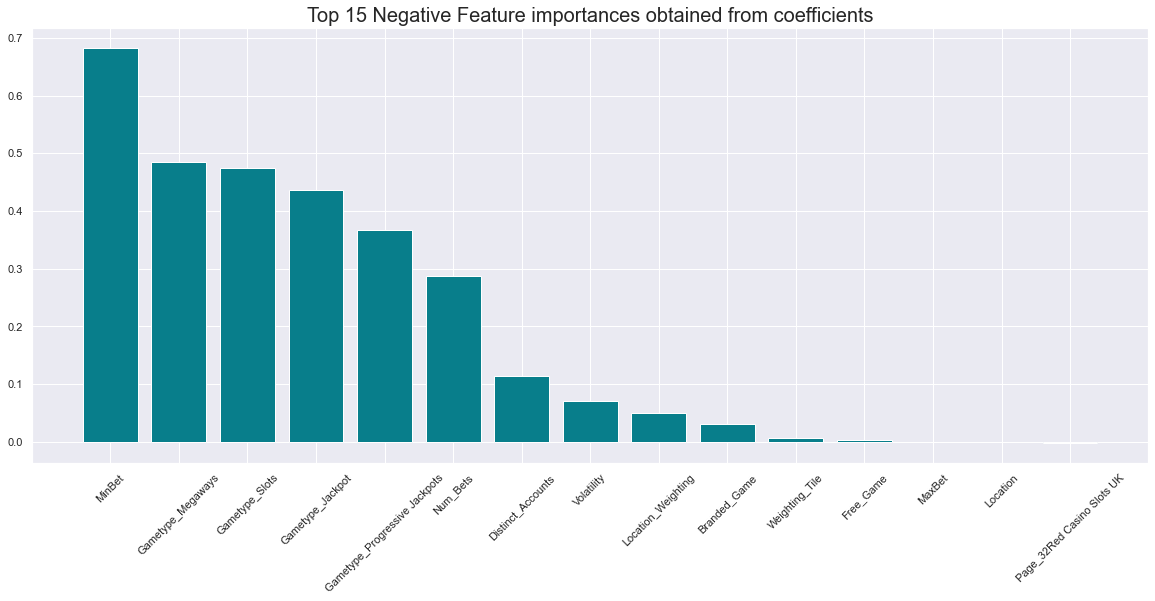

In [1361]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': reg.coef_
})

importances = importances.sort_values(by='Importance', ascending=False)
importances = importances[:15]

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Top 15 Negative Feature importances obtained from coefficients', size=20)
plt.xticks(rotation=45)
plt.show()

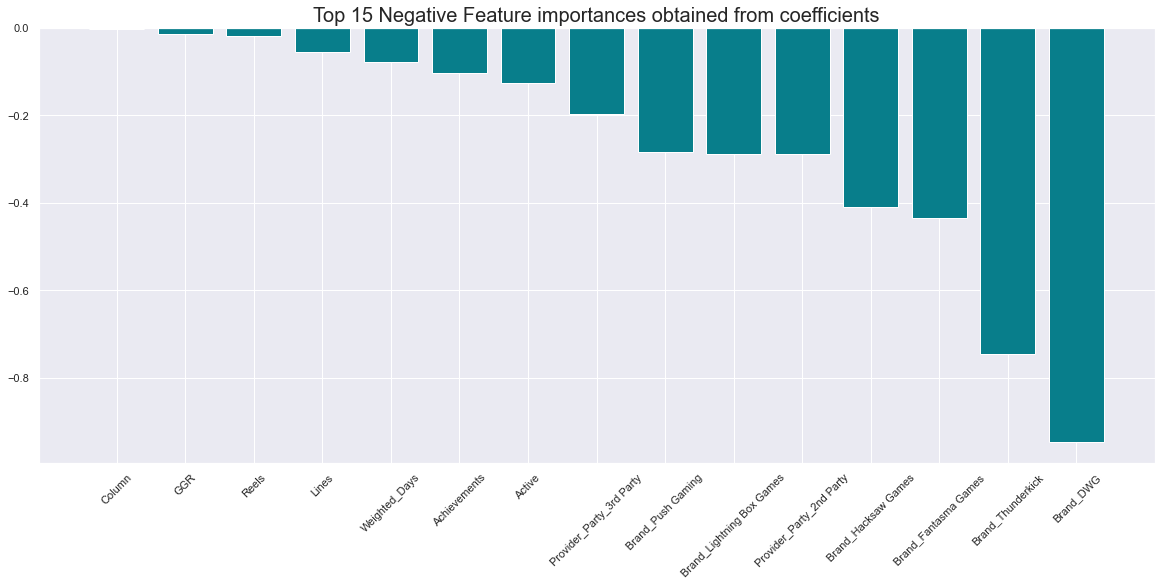

In [1362]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': reg.coef_
})

importances = importances.sort_values(by='Importance', ascending=False)
importances = importances[-15:]

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Top 15 Negative Feature importances obtained from coefficients', size=20)
plt.xticks(rotation=45)
plt.show()